# ConvNeXt-based v-CLR (VOC → Non-VOC) – Fast Training, AMP, Partial Fine-tuning

This notebook implements a ConvNeXt-based v-CLR training pipeline with:

- Precomputed `train_items` (no COCO object inside the Dataset) so DataLoader workers work on Windows.
- Random selection of depth vs. stylized view per step (always with the natural view).
- Mixed precision (AMP) for faster GPU training and lower memory.
- ConvNeXt-tiny backbone initialized from ImageNet and partially fine-tuned (last few stages unfrozen).


In [1]:
import os
import json
import math
import random
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.ops import box_iou, generalized_box_iou
from torchvision.models import convnext_tiny

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image

# Speed/predictability settings
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available – this notebook expects a GPU.")
device = torch.device("cuda")
print("Using device:", device, torch.cuda.get_device_name(0))


Using device: cuda NVIDIA GeForce RTX 4080


In [2]:
# === Configuration ===

DATA_ROOT = Path(r"C:\workspace\vclr\datasets")

COCO_ROOT = DATA_ROOT
COCO_TRAIN_JSON = COCO_ROOT / "annotations" / "instances_train2017.json"
COCO_VAL_JSON   = COCO_ROOT / "annotations" / "instances_val2017.json"

COCO_TRAIN_IMG_DIR = COCO_ROOT / "train2017"
COCO_VAL_IMG_DIR   = COCO_ROOT / "val2017"

# Extra views
DEPTH_TRAIN_DIR = DATA_ROOT / "train2017_depth_cmap"    # depth as .png
STYLE_TRAIN_DIR = DATA_ROOT / "style_coco_train2017"    # stylized view (if available)
EDGE_TRAIN_DIR  = None                                  # optional

# Non-VOC val + CutLER proposals
NONVOC_VAL_JSON       = DATA_ROOT / "uvo_nonvoc_val_rle.json"
CUTLER_PROPOSALS_JSON = DATA_ROOT / "vCLR_coco_train2017_top5.json"

NONVOC_IMG_DIR = DATA_ROOT / "uvo_videos_dense_frames"

# Training / eval hyperparameters
NUM_EPOCHS         = 1
BASE_LR            = 1e-4
TRAIN_BATCH_SIZE   = 20
VAL_BATCH_SIZE     = 20
TRAIN_NUM_WORKERS  = 0   # safe after we remove COCO from Dataset
VAL_NUM_WORKERS    = 0   # simpler eval
IMG_SIZE           = 650

# v-CLR loss weights
LAMBDA_GT    = 1.0
LAMBDA_OBJ   = 1.0
LAMBDA_SIM   = 10.0
LAMBDA_MATCH = 1.0

# MaskDINO/DINO-style detection and segmentation loss weights (from official configs)
# CLASS_WEIGHT, BOX_WEIGHT, GIOU_WEIGHT, MASK_WEIGHT, DICE_WEIGHT, NO_OBJECT_WEIGHT
LOSS_CLASS_WEIGHT      = 4.0   # classification term
LOSS_BOX_WEIGHT        = 5.0   # box L1 term
LOSS_GIOU_WEIGHT       = 2.0   # (G)IoU term
LOSS_MASK_BCE_WEIGHT   = 5.0   # mask BCE/focal term
LOSS_MASK_DICE_WEIGHT  = 5.0   # mask dice term
LOSS_NO_OBJECT_WEIGHT  = 0.1   # weight for "no object" queries

# Number of object queries per image (DETR / MaskDINO style)
NUM_QUERIES = 300

# VOC 20 classes in COCO naming
VOC_CLASS_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat",
    "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe",
    "tv"
]





In [3]:
# === COCO setup & VOC / Non-VOC split ===

coco_train = COCO(str(COCO_TRAIN_JSON))

name_to_id = {cat["name"]: cat["id"] for cat in coco_train.cats.values()}

voc_cat_ids = []
for name in VOC_CLASS_NAMES:
    if name not in name_to_id:
        raise ValueError(f"VOC class '{name}' not found in COCO categories.")
    voc_cat_ids.append(name_to_id[name])

voc_cat_ids = sorted(set(voc_cat_ids))
all_cat_ids = sorted(coco_train.cats.keys())
nonvoc_cat_ids = [cid for cid in all_cat_ids if cid not in voc_cat_ids]

print("VOC category ids:", voc_cat_ids)
print("Non-VOC category ids ({} total):".format(len(nonvoc_cat_ids)),
      nonvoc_cat_ids[:10], "...")


loading annotations into memory...
Done (t=5.61s)
creating index...
index created!
VOC category ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 72]
Non-VOC category ids (60 total): [10, 11, 13, 14, 15, 27, 28, 31, 32, 33] ...


In [8]:
# === Load CutLER proposals (COCO xywh -> xyxy for IoU/L1 with detector) ===

with open(CUTLER_PROPOSALS_JSON, "r") as f:
    cutler_data = json.load(f)

proposal_dict: Dict[int, List[Dict[str, torch.Tensor]]] = {}

def _xywh_to_xyxy(boxes_xywh: torch.Tensor) -> torch.Tensor:
    """Convert [x, y, w, h] -> [x1, y1, x2, y2] in the same coordinate system."""
    if boxes_xywh.ndim == 1:
        boxes_xywh = boxes_xywh.unsqueeze(0)
    boxes_xyxy = boxes_xywh.clone()
    boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]  # x2 = x + w
    boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]  # y2 = y + h
    return boxes_xyxy

if isinstance(cutler_data, dict) and "annotations" in cutler_data and "images" in cutler_data:
    # Standard COCO-style proposals: each annotation has bbox=[x,y,w,h] in original pixels
    boxes_by_image = defaultdict(list)
    scores_by_image = defaultdict(list)

    for ann in cutler_data["annotations"]:
        img_id = int(ann["image_id"])
        boxes_by_image[img_id].append(ann["bbox"])               # COCO xywh
        scores_by_image[img_id].append(ann.get("score", 1.0))

    for img_id, boxes_list in boxes_by_image.items():
        boxes_xywh = torch.tensor(boxes_list, dtype=torch.float32)
        boxes_xyxy = _xywh_to_xyxy(boxes_xywh)
        scores = torch.tensor(scores_by_image[img_id], dtype=torch.float32)
        proposal_dict[img_id] = [{"boxes": boxes_xyxy, "scores": scores}]

    print(f"Loaded CutLER-style proposals (COCO JSON) for {len(proposal_dict)} training images.")

elif isinstance(cutler_data, dict):
    # Fallback: dictionary keyed directly by image_id (as string) -> boxes / {boxes,scores}
    skipped_meta_keys: List[str] = []
    for k, v in cutler_data.items():
        try:
            img_id = int(k)
        except ValueError:
            skipped_meta_keys.append(k)
            continue

        if isinstance(v, dict) and "boxes" in v:
            boxes_xywh = torch.tensor(v["boxes"], dtype=torch.float32)
            scores = torch.tensor(
                v.get("scores", [1.0] * len(boxes_xywh)),
                dtype=torch.float32,
            )
        else:
            boxes_xywh = torch.tensor(v, dtype=torch.float32)
            scores = torch.ones(len(boxes_xywh), dtype=torch.float32)

        boxes_xyxy = _xywh_to_xyxy(boxes_xywh)
        proposal_dict[img_id] = [{"boxes": boxes_xyxy, "scores": scores}]

    print("Loaded dict-style proposals for", len(proposal_dict), "training images")
    if skipped_meta_keys:
        print("Skipped non-image keys:", skipped_meta_keys)
else:
    raise ValueError("Unrecognized CUTLER_PROPOSALS_JSON format for proposals.")

# Small sanity check: print one entry (id and shapes)
_example_key = next(iter(proposal_dict.keys()))
_example_entry = proposal_dict[_example_key][0]
print(
    f"Example proposals for image_id={_example_key}: "
    f"boxes={_example_entry['boxes'].shape}, scores={_example_entry['scores'].shape}"
)


Loaded CutLER-style proposals (COCO JSON) for 118287 training images.
Example proposals for image_id=558840: boxes=torch.Size([16, 4]), scores=torch.Size([16])


In [4]:
# === Precompute train_items for a Windows-safe Dataset ===

train_items: List[Dict[str, Any]] = []

for img_id in coco_train.getImgIds():
    img_info = coco_train.loadImgs([img_id])[0]
    ann_ids = coco_train.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco_train.loadAnns(ann_ids)

    boxes = []
    iscrowd = []
    segs = []

    for a in anns:
        if a["category_id"] not in voc_cat_ids:
            continue
        if "bbox" not in a:
            continue
        boxes.append(a["bbox"])              # [x, y, w, h]
        iscrowd.append(a.get("iscrowd", 0))
        segs.append(a.get("segmentation", None))

    item = {
        "image_id": img_id,
        "file_name": img_info["file_name"],
        "boxes": boxes,
        "iscrowd": iscrowd,
        "masks": segs,
        "orig_size": [img_info["height"], img_info["width"]],  # [H, W]
    }
    train_items.append(item)

print("len(train_items) =", len(train_items))


len(train_items) = 118287


In [5]:
%%writefile vclr_dataset3.py
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import torch
from torch.utils.data import Dataset
import copy
from PIL import Image
import pycocotools.mask as mask_utils


class VCLRTrainSubset(Dataset):
    """
    Windows-safe v-CLR training subset.

    Each entry in `items` is a Python dict:
      - image_id: int
      - file_name: str
      - boxes: List[List[float]] in xywh (original pixels)
      - iscrowd: List[int]
      - masks: List[segmentation] (COCO polygons or RLE)
      - orig_size: [H, W]

    `proposals` is:
      image_id -> list of { "boxes": Tensor[K,4] (xywh), "scores": Tensor[K] }.
    """

    def __init__(
        self,
        items: List[Dict[str, Any]],
        img_dir: Path,
        depth_dir: Optional[str] = None,
        stylized_dir: Optional[str] = None,
        edge_dir: Optional[str] = None,
        proposals: Optional[Dict[int, List[Dict[str, torch.Tensor]]]] = None,
        transform: Optional[Any] = None,
    ):
        self.items = items
        self.img_dir = Path(img_dir)
        self.depth_dir = Path(depth_dir) if depth_dir is not None else None
        self.stylized_dir = Path(stylized_dir) if stylized_dir is not None else None
        self.edge_dir = Path(edge_dir) if edge_dir is not None else None
        self.proposals = proposals or {}
        self.transform = transform

    def __len__(self) -> int:
        return len(self.items)

    def _load_optional_view(self, root: Optional[Path], file_name: str) -> Optional[Image.Image]:
        if root is None:
            return None
        path = root / file_name
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is None or not alt.is_file():
                return None
            path = alt
        return Image.open(path).convert("RGB")

    def _decode_masks(self, segs, h: int, w: int) -> torch.Tensor:
        if not segs:
            # Legit: there are no masks for this image
            return torch.zeros((0, h, w), dtype=torch.uint8)

        decoded = []
        failed = 0

        for s in segs:
            if s is None:
                failed += 1
                continue

            rle = None
            if isinstance(s, list):
                rles = mask_utils.frPyObjects(s, h, w)
                rle = mask_utils.merge(rles) if isinstance(rles, list) else rles

            elif isinstance(s, dict) and "counts" in s:
                if isinstance(s["counts"], list):
                    rle = mask_utils.frPyObjects(s, h, w)
                    if isinstance(rle, list):
                        rle = mask_utils.merge(rle)
                else:
                    rle = s

            if rle is None:
                failed += 1
                continue

            m = mask_utils.decode(rle).astype("uint8")
            decoded.append(m)

        if not decoded:
            # segs was non-empty but we failed to decode all of them
            # --> better to raise or log, not silently pretend it's background
            raise RuntimeError(
                f"Failed to decode any masks for image; got {len(segs)} seg entries, all invalid."
            )

        return torch.from_numpy(np.stack(decoded, axis=0))




    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = self.items[idx]
        img_id = int(item["image_id"])
        file_name = item["file_name"]

        # Natural image
        path = self.img_dir / file_name
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is None or not alt.is_file():
                raise FileNotFoundError(f"Image not found: {path} (alt={alt})")
            path = alt
        image_nat = Image.open(path).convert("RGB")

        h0, w0 = item["orig_size"][0], item["orig_size"][1]

        # Extra views
        image_depth = self._load_optional_view(self.depth_dir, file_name)
        image_style = self._load_optional_view(self.stylized_dir, file_name)
        image_edge  = self._load_optional_view(self.edge_dir, file_name)

        # Ground-truth boxes (still in original image coords here)
        boxes = torch.as_tensor(item.get("boxes", []), dtype=torch.float32)
        if boxes.numel() == 0:
            boxes = boxes.reshape(0, 4)

        iscrowd = torch.as_tensor(item.get("iscrowd", []), dtype=torch.int64)
        if iscrowd.numel() == 0:
            iscrowd = iscrowd.reshape(0)

        segs = item.get("masks", [])
        masks = self._decode_masks(segs, h0, w0)  # (N, H0, W0)
        if masks.shape[0] != boxes.shape[0]:
            masks = torch.zeros((boxes.shape[0], h0, w0), dtype=torch.uint8)

        # Class-agnostic: all foreground
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target: Dict[str, Any] = {
            "boxes": boxes,
            "labels": labels,
            "iscrowd": iscrowd,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "orig_size": torch.tensor([h0, w0], dtype=torch.float32),
        }

        # 🔧 FIX: deep-copy proposals so transforms cannot mutate self.proposals
        props_raw = self.proposals.get(img_id, [])
        props = copy.deepcopy(props_raw)

        sample: Dict[str, Any] = {
            "image_nat": image_nat,
            "image_depth": image_depth,
            "image_style": image_style,
            "image_edge": image_edge,
            "target": target,
            "proposals": props,
        }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

Overwriting vclr_dataset3.py


In [6]:
# === Dataset transforms WITHOUT resize/normalize or bbox scaling + padded collate ===
import importlib
import torchvision.transforms as T
import torch.nn.functional as F
from typing import Dict, Any, List

import vclr_dataset3
importlib.reload(vclr_dataset3)
from vclr_dataset3 import VCLRTrainSubset


class VCLRTransform:
    """
    v-CLR transform with resizing to IMG_SIZE, tensor conversion, and box/mask/proposal scaling.
    """

    def __init__(self, img_size: int = IMG_SIZE):
        self.img_size = img_size
        self.resize = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()  # HWC uint8 -> CHW float [0,1]

    def _process_view(self, img):
        if img is None:
            return None
        return self.to_tensor(self.resize(img))

    def __call__(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        target = sample["target"]
        h0, w0 = target["orig_size"].tolist()
        sx = self.img_size / max(1.0, w0)
        sy = self.img_size / max(1.0, h0)

        # Views -> resize then tensor
        sample["image_nat"]   = self._process_view(sample["image_nat"])
        sample["image_depth"] = self._process_view(sample["image_depth"])
        sample["image_style"] = self._process_view(sample["image_style"])
        sample["image_edge"]  = self._process_view(sample["image_edge"])

        # Scale GT boxes (xywh) and masks
        boxes = target["boxes"].clone().float()
        if boxes.numel() > 0:
            scale_xywh = torch.tensor([sx, sy, sx, sy], device=boxes.device, dtype=boxes.dtype)
            boxes = boxes * scale_xywh
        target["boxes"] = boxes

        if "masks" in target and target["masks"] is not None:
            masks = target["masks"].unsqueeze(1).float()  # [N,1,H,W]
            masks = F.interpolate(masks, size=(self.img_size, self.img_size), mode="nearest")
            target["masks"] = masks.squeeze(1).to(dtype=torch.uint8)

        # Update orig_size to resized dims
        target["orig_size"] = torch.tensor([self.img_size, self.img_size], dtype=torch.float32)
        sample["target"] = target

        # Scale proposals (xyxy)
        scale_xyxy = torch.tensor([sx, sy, sx, sy], dtype=torch.float32)
        for entry in sample["proposals"]:
            entry["boxes"] = entry["boxes"].clone().float() * scale_xyxy

        return sample


def _pad_and_stack(images: List[Any]) -> Any:
    """
    Pad variable-size CHW images to a common (H_max, W_max) and stack to [B, C, H, W].

    If the entire list is None (i.e., view missing for all samples), return None.
    If some are None and some are tensors, we bail (that indicates a dataset bug).
    """
    # All missing
    if all(img is None for img in images):
        return None

    # Mixed None / Tensor is not supported → this should not happen in v-CLR setup
    if any(img is None for img in images):
        raise RuntimeError("Mixed None and Tensor in view batch; fix Dataset/Collate.")

    # Now all entries are tensors with possibly different H, W
    C = images[0].shape[0]
    h_list = [img.shape[1] for img in images]
    w_list = [img.shape[2] for img in images]
    H_max = max(h_list)
    W_max = max(w_list)

    padded = []
    for img in images:
        _, H, W = img.shape
        pad_h = H_max - H
        pad_w = W_max - W
        # Pad only on bottom and right: (left, right, top, bottom)
        padded_img = F.pad(img, (0, pad_w, 0, pad_h))
        padded.append(padded_img)

    return torch.stack(padded, dim=0)


def vclr_collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    out = {
        "image_nat": [],
        "image_depth": [],
        "image_style": [],
        "image_edge": [],
        "targets": [],
        "proposals": [],
    }
    for b in batch:
        out["image_nat"].append(b["image_nat"])
        out["image_depth"].append(b["image_depth"])
        out["image_style"].append(b["image_style"])
        out["image_edge"].append(b["image_edge"])
        out["targets"].append(b["target"])
        out["proposals"].append(b["proposals"])

    # Pad each view separately. No resizing, only zero-padding, so box coordinates
    # remain valid in the original top-left region.
    out["image_nat"]   = _pad_and_stack(out["image_nat"])
    out["image_depth"] = _pad_and_stack(out["image_depth"])
    out["image_style"] = _pad_and_stack(out["image_style"])
    out["image_edge"]  = _pad_and_stack(out["image_edge"])

    return out


# === Build datasets/loaders ===

train_transform = VCLRTransform(img_size=IMG_SIZE)

indices = list(range(len(train_items)))
rng = random.Random(SEED)
rng.shuffle(indices)

val_frac = 0.1
split = int((1.0 - val_frac) * len(indices))
train_indices = indices[:split]
val_indices   = indices[split:]

train_items_train = [train_items[i] for i in train_indices]
val_items_loss    = [train_items[i] for i in val_indices]

print("Train items:", len(train_items_train), "Val items (loss):", len(val_items_loss))

train_dataset = VCLRTrainSubset(
    items=train_items_train,
    img_dir=COCO_TRAIN_IMG_DIR,
    depth_dir=str(DEPTH_TRAIN_DIR),
    stylized_dir=str(STYLE_TRAIN_DIR),
    edge_dir=str(EDGE_TRAIN_DIR) if EDGE_TRAIN_DIR is not None else None,
    proposals=proposal_dict,
    transform=train_transform,
)

val_dataset_loss = VCLRTrainSubset(
    items=val_items_loss,
    img_dir=COCO_TRAIN_IMG_DIR,
    depth_dir=str(DEPTH_TRAIN_DIR),
    stylized_dir=str(STYLE_TRAIN_DIR),
    edge_dir=str(EDGE_TRAIN_DIR) if EDGE_TRAIN_DIR is not None else None,
    proposals=proposal_dict,
    transform=train_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False,
    collate_fn=vclr_collate,
)

val_loader_loss = DataLoader(
    val_dataset_loss,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False,
    collate_fn=vclr_collate,
)

print("Train batches:", len(train_loader), "Val (loss) batches:", len(val_loader_loss))




Train items: 106458 Val items (loss): 11829


NameError: name 'proposal_dict' is not defined

In [9]:
# === Box utilities ===

def box_xywh_to_cxcywh(boxes: torch.Tensor) -> torch.Tensor:
    x, y, w, h = boxes.unbind(-1)
    cx = x + 0.5 * w
    cy = y + 0.5 * h
    return torch.stack([cx, cy, w, h], dim=-1)

def box_cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


In [5]:
# === YOLACT-based detector for v-CLR (replaces ConvNeXtDetector + TS wrapper) ===
import copy
import torch.nn as nn
from pathlib import Path

# ---- YOLACT imports: adapt if your fork uses different paths ----
from yolact import Yolact
from data.config import cfg, set_cfg
from layers.modules.multibox_loss import MultiBoxLoss  # or your MultiBoxLoss path


class YOLACTVCLRDetector(nn.Module):
    """
    Thin wrapper around a YOLACT model that:

      * For training:
          - Runs YOLACT forward
          - Uses YOLACT's MultiBoxLoss (classification, bbox, mask, etc.)
          - Returns that full loss dict as `loss_dict` (L_gt in v-CLR will be the sum of
            ALL these components, no pseudo wiring).

      * For v-CLR:
          - Exposes per-instance `boxes`, `scores`, `masks`, and `query_feats`
            (we use YOLACT's mask coefficients as the instance embedding).
    """

    def __init__(
        self,
        yolact_net: Yolact,
        criterion: MultiBoxLoss,
        d_model: int = 32,
    ):
        super().__init__()
        self.yolact = yolact_net
        self.criterion = criterion
        self.d_model = d_model  # dimension of query_feats; mask coeff dim is a good choice

    def _to_yolact_targets(self, targets: List[Dict[str, Any]]) -> List[Dict[str, torch.Tensor]]:
        """
        Convert our v-CLR style targets to what your YOLACT MultiBoxLoss expects.

        Here we assume your MultiBoxLoss takes a list of dicts with:
            - 'boxes': [Ni, 4] in xywh or xyxy (whichever your loss expects)
            - 'labels': [Ni]
            - 'masks':  [Ni, H, W] (optional, for mask loss)
        If your fork expects a different structure, adapt this function
        but keep the idea: we pass ground truth directly, no fake losses.
        """
        out = []
        for t in targets:
            dev = self.yolact.device if hasattr(self.yolact, "device") else t["boxes"].device
            gt = {
                "boxes": t["boxes"].to(dev),
                "labels": t["labels"].to(dev),
            }
            if "masks" in t and t["masks"] is not None:
                gt["masks"] = t["masks"].to(dev)
            out.append(gt)
        return out

    def _build_yolact_supervision(
        self,
        targets: List[Dict[str, Any]],
        img_hw: Tuple[int, int],
        device: torch.device,
    ) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[int]]:
        """
        Build the exact inputs MultiBoxLoss wants, all on `device`.

        targets_y: list of [Ni, 5] tensors  (x1,y1,x2,y2,label), normalized to [0,1]
        masks_y  : list of [Ni, H, W] tensors (float32)
        num_crowds: list[int], here always 0 (no crowds)
        """
        H, W = img_hw

        yolact_targets: List[torch.Tensor] = []
        yolact_masks:   List[torch.Tensor] = []
        num_crowds:     List[int] = []

        for t in targets:
            boxes_xywh = t["boxes"].to(device=device, dtype=torch.float32)   # [N,4], pixels
            labels     = t["labels"].to(device=device, dtype=torch.long)     # [N]
            N = boxes_xywh.size(0)

            # -------------------------------
            # Corner case: no GT in this image
            # -------------------------------
            if N == 0:
                # YOLACT's MultiBoxLoss expects at least one "truth" row,
                # otherwise jaccard(...).max(0) blows up.
                #
                # We create a single dummy GT that covers the whole image,
                # with a valid class index 0 (COCO-style: 0..num_classes-2).
                # IoU with priors will be low for most anchors; loss becomes
                # essentially "background / negative-only" for this image.
                dummy_box_norm = torch.tensor(
                    [[0.0, 0.0, 1.0, 1.0]],  # [x1,y1,x2,y2] in [0,1]
                    device=device,
                    dtype=torch.float32,
                )
                dummy_label = torch.tensor(
                    [[0.0]],  # one valid class index
                    device=device,
                    dtype=torch.float32,
                )
                gt = torch.cat([dummy_box_norm, dummy_label], dim=-1)  # [1,5]

                # Dummy mask (no actual object, but shape is correct)
                masks = torch.zeros((1, H, W), device=device, dtype=torch.float32)

                yolact_targets.append(gt)
                yolact_masks.append(masks)
                num_crowds.append(0)
                continue

            # -------------------------------
            # Normal path: N >= 1
            # -------------------------------
            # xywh -> xyxy in pixels
            x, y, w, h = boxes_xywh.unbind(-1)
            x1 = x
            y1 = y
            x2 = x + w
            y2 = y + h
            boxes_xyxy = torch.stack([x1, y1, x2, y2], dim=-1)  # [N,4], pixels

            # Normalize to [0,1] wrt current training size
            scale = torch.tensor([W, H, W, H], device=device, dtype=torch.float32)
            boxes_norm = boxes_xyxy / scale  # [N,4] in [0,1]

            labels_float = labels.to(dtype=torch.float32)
            gt = torch.cat([boxes_norm, labels_float.unsqueeze(-1)], dim=-1)  # [N,5]
            yolact_targets.append(gt)

            if "masks" in t and t["masks"] is not None:
                masks = t["masks"].to(device=device, dtype=torch.float32)
            else:
                masks = torch.zeros((N, H, W), device=device, dtype=torch.float32)
            yolact_masks.append(masks)

            num_crowds.append(0)

        return yolact_targets, yolact_masks, num_crowds

    

    @torch.no_grad()
    def _to_vclr_outputs(
        self,
        preds: Any,
        img_hw: Tuple[int, int],
    ) -> List[Dict[str, torch.Tensor]]:
        """
        Map this YOLACT fork's detection outputs to the v-CLR format,
        tolerating images with zero detections (None/empty).
        """
        outputs: List[Dict[str, torch.Tensor]] = []

        def _empty_output(device: torch.device) -> Dict[str, torch.Tensor]:
            return {
                "boxes": torch.zeros((0, 4), device=device, dtype=torch.float32),
                "scores": torch.zeros((0,), device=device, dtype=torch.float32),
                "masks": None,
                "query_feats": torch.zeros((0, self.d_model), device=device, dtype=torch.float32),
            }

        if preds is None:
            return outputs

        if not isinstance(preds, list):
            preds = [preds]

        for sample_idx, sample in enumerate(preds):
            # Default device fallback
            fallback_device = getattr(self.yolact, "device", torch.device("cpu"))

            if not isinstance(sample, dict):
                outputs.append(_empty_output(fallback_device))
                continue

            det_obj = sample.get("detection", None)

            if det_obj is None:
                outputs.append(_empty_output(fallback_device))
                continue

            if isinstance(det_obj, list):
                if len(det_obj) == 0 or not isinstance(det_obj[0], dict):
                    outputs.append(_empty_output(fallback_device))
                    continue
                det = det_obj[0]
            elif isinstance(det_obj, dict):
                det = det_obj
            else:
                outputs.append(_empty_output(fallback_device))
                continue

            boxes = det.get("box", None)
            scores = det.get("score", None)
            coeffs = det.get("mask", None)

            if boxes is None or scores is None:
                outputs.append(_empty_output(fallback_device))
                continue

            if not torch.is_tensor(boxes):
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
            else:
                boxes = boxes.float()

            # Scale boxes to current image size (pad_hw)
            H, W = img_hw
            scale_xyxy = torch.tensor([W, H, W, H], device=boxes.device, dtype=boxes.dtype)
            boxes = boxes * scale_xyxy

            device = boxes.device

            scores_t = torch.as_tensor(scores, dtype=torch.float32, device=device)
            if scores_t.dim() == 0:
                scores_t = scores_t.view(1)

            if coeffs is not None:
                if not torch.is_tensor(coeffs):
                    query_feats = torch.as_tensor(coeffs, dtype=torch.float32, device=device)
                else:
                    query_feats = coeffs.to(device=device, dtype=torch.float32)

                if query_feats.dim() == 1:
                    query_feats = query_feats.unsqueeze(0)

                if query_feats.size(1) != self.d_model:
                    d = query_feats.size(1)
                    if d > self.d_model:
                        query_feats = query_feats[:, : self.d_model]
                    else:
                        pad = self.d_model - d
                        query_feats = F.pad(query_feats, (0, pad), mode="constant", value=0.0)
            else:
                query_feats = torch.zeros((boxes.shape[0], self.d_model), device=device, dtype=torch.float32)

            outputs.append(
                {
                    "boxes": boxes,              # [N, 4] xyxy, no scaling
                    "scores": scores_t,          # [N]
                    "masks": None,               # or compute from proto+coeffs if needed later
                    "query_feats": query_feats,  # [N, d_model] real mask coeffs
                }
            )

        return outputs


    def forward(
        self,
        images: torch.Tensor,
        targets: Optional[List[Dict[str, Any]]] = None,
        proposals: Optional[List[Any]] = None,
        view_name: str = "nat",
    ):
        B, _, H, W = images.shape
        device = images.device

        # Keep channels_last for speed, but stay on the same device
        images = images.to(memory_format=torch.channels_last)

        # ----------------- TRAIN -----------------
        if self.training and targets is not None:
            # Check if outer code is in AMP autocast
            use_amp = torch.is_autocast_enabled()

            if use_amp:
                # Disable autocast just for YOLACT + MultiBoxLoss; run in float32
                with torch.cuda.amp.autocast(enabled=False):
                    images_f32 = images.float()

                    # 1) Raw YOLACT predictions (float32)
                    predictions = self.yolact(images_f32)

                    # 2) Build GT on same device
                    yolact_targets, yolact_masks, num_crowds = self._build_yolact_supervision(
                        targets, img_hw=(H, W), device=device
                    )

                    # 3) MultiBoxLoss in full float32 (no AMP)
                    loss_dict_raw = self.criterion(
                        self.yolact,      # net
                        predictions,      # (loc, conf, mask, priors, proto)
                        yolact_targets,   # list[Tensor], cuda
                        yolact_masks,     # list[Tensor], cuda
                        num_crowds,       # list[int]
                    )
            else:
                # No AMP: run straight
                predictions = self.yolact(images)

                yolact_targets, yolact_masks, num_crowds = self._build_yolact_supervision(
                    targets, img_hw=(H, W), device=device
                )

                loss_dict_raw = self.criterion(
                    self.yolact,
                    predictions,
                    yolact_targets,
                    yolact_masks,
                    num_crowds,
                )

            if not isinstance(loss_dict_raw, dict):
                raise RuntimeError(
                    f"Expected MultiBoxLoss to return a dict, got {type(loss_dict_raw)}"
                )

            loss_dict = {
                k: (v if torch.is_tensor(v) else torch.tensor(v, device=device))
                for k, v in loss_dict_raw.items()
            }

            # 4) For v-CLR we need per-image detections / mask-coef embeddings
            with torch.no_grad():
                det_list = self.yolact.detect(predictions, self.yolact)

        # ----------------- EVAL / TEACHER -----------------
        else:
            with torch.no_grad():
                det_list = self.yolact(images)
            loss_dict = {}

        # Convert detections -> v-CLR outputs (no extra bbox scaling)
        outputs_list = self._to_vclr_outputs(det_list, img_hw=(H, W))

        return outputs_list, loss_dict


# ---- Build YOLACT model + criterion and wrap in Teacher–Student v-CLR ----

# Select a config; use the one that matches the pretrained checkpoint
set_cfg("yolact_resnet50_config")  # yolact_resnet50_54_800000.pth

# Path to the pretrained YOLACT checkpoint
WEIGHTS_DIR = Path(r"C:\Users\pshl7\OneDrive\Desktop\School\Fall 2025\DL\Term Project\Project\YOLACT")  # adjust if your repo uses a different folder
YOLACT_CKPT = WEIGHTS_DIR / "yolact_resnet50_54_800000.pth"

if not YOLACT_CKPT.is_file():
    raise FileNotFoundError(
        f"Expected pretrained YOLACT checkpoint at {YOLACT_CKPT}. "
        "Download 'yolact_resnet50_54_800000.pth' and place it there."
    )

# Build YOLACT and load pretrained COCO weights
base_yolact = Yolact()
base_yolact.load_weights(str(YOLACT_CKPT))
base_yolact = base_yolact.to(device)
# Lower detection conf threshold during training to keep boxes for L_obj/L_sim
if hasattr(base_yolact, "detect"):
    base_yolact.detect.conf_thresh = 0.01
base_yolact.train()

# Freeze backbone; keep FPN and heads trainable
for p in base_yolact.backbone.parameters():
    p.requires_grad = False
if hasattr(base_yolact, "fpn") and base_yolact.fpn is not None:
    for p in base_yolact.fpn.parameters():
        p.requires_grad = True
for layer in getattr(base_yolact, "prediction_layers", []):
    for p in layer.parameters():
        p.requires_grad = True
for _, module in [
    ("proto", getattr(base_yolact, "proto_net", None)),
    ("semantic", getattr(base_yolact, "semantic_seg_conv", None)),
    ("class_existence", getattr(base_yolact, "class_existence_fc", None)),
]:
    if module is not None:
        for p in module.parameters():
            p.requires_grad = True

# YOLACT's own MultiBoxLoss (classification, bbox, masks, etc.)
yolact_criterion = MultiBoxLoss(
    num_classes=cfg.num_classes,
    pos_threshold=0.5,
    neg_threshold=0.4,
    negpos_ratio=3,
)

# mask_dim from cfg is a natural choice for query feature dimension
yolact_detector = YOLACTVCLRDetector(
    yolact_net=base_yolact,
    criterion=yolact_criterion,
    d_model=cfg.mask_dim,
).to(device)

yolact_detector = yolact_detector.to(memory_format=torch.channels_last)


class TeacherStudentVCLR(nn.Module):
    """
    Same TS wrapper you had before, now around YOLACTVCLRDetector.
    Teacher is EMA of student; teacher used for nat branch; student for all gradients.
    """

    def __init__(self, base_detector: nn.Module, ema_momentum: float = 0.999):
        super().__init__()
        self.student = base_detector

        # Deep copy the student to initialize the teacher
        self.teacher = copy.deepcopy(base_detector)

        # IMPORTANT: detach teacher params before freezing to avoid
        # "you can only change requires_grad flags of leaf variables"
        for p in self.teacher.parameters():
            p.detach_()           # break grad graph, make it a leaf
            p.requires_grad = False

        self.ema_m = ema_momentum

    @torch.no_grad()
    def update_teacher(self):
        m = self.ema_m
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            t_param.data.mul_(m).add_(s_param.data, alpha=1.0 - m)

    def train(self, mode: bool = True):
        self.student.train(mode)
        self.teacher.eval()
        self.training = mode
        return self

    def eval(self):  # type: ignore[override]
        return self.train(False)


# Wrap YOLACT detector with EMA teacher–student
model = TeacherStudentVCLR(yolact_detector, ema_momentum=0.999).to(device)

# Channels-last for both branches
model.student = model.student.to(memory_format=torch.channels_last)
model.teacher = model.teacher.to(memory_format=torch.channels_last)

# --- Optimizer (single LR group is fine; you can split later if needed) ---
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=BASE_LR,
    weight_decay=1e-4,
)

for pg in optimizer.param_groups:
    pg["initial_lr"] = pg["lr"]


def adjust_lr(optimizer, epoch: int):
    """
    Simple step schedule: drop LR by 10× after epoch 7.
    """
    factor = 0.1 if epoch >= 7 else 1.0
    for pg in optimizer.param_groups:
        pg["lr"] = pg["initial_lr"] * factor


print(
    "Total trainable params:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)









Total trainable params: 7656911


In [11]:
# === v-CLR auxiliary losses (L_obj, L_sim) – NO bbox scaling here ===

def cosine_sim_loss(q1: torch.Tensor, q2: torch.Tensor) -> torch.Tensor:
    q1 = F.normalize(q1, dim=-1)
    q2 = F.normalize(q2, dim=-1)
    return (1.0 - (q1 * q2).sum(dim=-1)).mean()


def match_proposals_to_predictions(
    proposal_boxes: torch.Tensor,
    pred_boxes: torch.Tensor,
    iou_thresh: float = 0.3,
    max_pairs: int = 64,
):
    """Return proposal->pred indices and their IoU weights (bidirectional caller can add reverse)."""
    if proposal_boxes.numel() == 0 or pred_boxes.numel() == 0:
        device = pred_boxes.device if torch.is_tensor(pred_boxes) else torch.device("cpu")
        empty = torch.empty(0, dtype=torch.long, device=device)
        return empty, empty, empty

    ious = box_iou(proposal_boxes, pred_boxes)  # [Np, Npred]
    best_iou, best_idx = ious.max(dim=1)        # for each proposal: best pred

    keep = best_iou > iou_thresh
    idx_p = torch.nonzero(keep, as_tuple=False).squeeze(-1)
    idx_pred = best_idx[keep]
    iou_keep = best_iou[keep]

    if idx_p.numel() > max_pairs:
        idx_p = idx_p[:max_pairs]
        idx_pred = idx_pred[:max_pairs]
        iou_keep = iou_keep[:max_pairs]

    return idx_p, idx_pred, iou_keep


def _intersect1d_with_indices(a: torch.Tensor, b: torch.Tensor):
    assert a.dim() == 1 and b.dim() == 1
    device = a.device
    common_vals = []
    idx_a = []
    idx_b = []

    for i in range(a.numel()):
        v = a[i]
        matches = (b == v).nonzero(as_tuple=False)
        if matches.numel() > 0:
            common_vals.append(v)
            idx_a.append(i)
            idx_b.append(matches[0].item())

    if len(common_vals) == 0:
        return (
            torch.empty(0, dtype=a.dtype, device=device),
            torch.empty(0, dtype=torch.long, device=device),
            torch.empty(0, dtype=torch.long, device=device),
        )

    common = torch.stack(common_vals).to(device)
    idx_a_local = torch.tensor(idx_a, dtype=torch.long, device=device)
    idx_b_local = torch.tensor(idx_b, dtype=torch.long, device=device)
    return common, idx_a_local, idx_b_local


def compute_vclr_losses(
    outputs_nat,   loss_nat,
    outputs_depth, loss_depth,
    outputs_style, loss_style,
    proposals_batch,
    targets,
    pad_hw: Tuple[int, int],
) -> Dict[str, torch.Tensor]:
    """
    Aggregate:
      - L_gt   : sum of all detector losses (YOLACT) for nat + depth/style
      - L_obj  : proposal–prediction L1 alignment across views (scaled to padded frame, IoU-weighted, bidirectional)
      - L_sim  : cosine similarity between query features across views, matched via shared proposals
    """
    device = outputs_nat[0]["boxes"].device
    pad_h, pad_w = pad_hw

    def sum_loss_dict(ld: Dict[str, torch.Tensor]) -> torch.Tensor:
        if not ld:
            return torch.tensor(0.0, device=device)
        vals = []
        for v in ld.values():
            if not torch.is_tensor(v):
                continue
            v = v.to(device=device, dtype=torch.float32)
            if not torch.isfinite(v):
                continue
            vals.append(v)
        if not vals:
            return torch.tensor(0.0, device=device)
        return torch.stack(vals).sum()

    def scale_props_to_pad(prop_boxes: torch.Tensor, orig_size: torch.Tensor) -> torch.Tensor:
        # prop_boxes: xyxy in original pixels; orig_size: [H, W]
        h0, w0 = orig_size.tolist()
        sx = pad_w / max(1.0, w0)
        sy = pad_h / max(1.0, h0)
        scale = torch.tensor([sx, sy, sx, sy], device=prop_boxes.device, dtype=torch.float32)
        return prop_boxes * scale

    # ---- Ground-truth supervised term L_gt (YOLACT losses) ----
    L_gt_nat   = sum_loss_dict(loss_nat)
    L_gt_depth = sum_loss_dict(loss_depth)
    L_gt_style = sum_loss_dict(loss_style)
    L_gt = L_gt_nat + L_gt_depth + L_gt_style

    # ---- Proposal-objectness term L_obj and query-similarity term L_sim ----
    L_obj_list: List[torch.Tensor] = []
    L_sim_list: List[torch.Tensor] = []

    B = len(outputs_nat)

    for b in range(B):
        props = proposals_batch[b]
        if not props:
            continue

        orig_size = targets[b]["orig_size"].to(device)
        prop_boxes = props[0]["boxes"].to(device)
        prop_boxes = scale_props_to_pad(prop_boxes, orig_size)  # now in padded frame

        nat_out   = outputs_nat[b]
        depth_out = outputs_depth[b] if outputs_depth else None
        style_out = outputs_style[b] if outputs_style else None

        def bidir_pairs(prop_boxes, pred_out):
            """Collect bidirectional matches with IoU weights."""
            if pred_out is None or pred_out["boxes"].numel() == 0:
                return {}
            pred_boxes = pred_out["boxes"]
            pairs = {}
            # prop -> pred
            idx_p, idx_pred, ious = match_proposals_to_predictions(prop_boxes, pred_boxes)
            for p_idx, pr_idx, iou in zip(idx_p.tolist(), idx_pred.tolist(), ious.tolist()):
                pairs[(p_idx, pr_idx)] = max(pairs.get((p_idx, pr_idx), 0.0), float(iou))
            # pred -> prop
            idx_p_r, idx_pred_r, ious_r = match_proposals_to_predictions(pred_boxes, prop_boxes)
            for pr_idx, p_idx, iou in zip(idx_p_r.tolist(), idx_pred_r.tolist(), ious_r.tolist()):
                pairs[(p_idx, pr_idx)] = max(pairs.get((p_idx, pr_idx), 0.0), float(iou))
            return pairs

        nat_pairs   = bidir_pairs(prop_boxes, nat_out)
        depth_pairs = bidir_pairs(prop_boxes, depth_out)
        style_pairs = bidir_pairs(prop_boxes, style_out)

        # 1) L_obj: IoU-weighted L1 across all pairs from all views
        for pairs, out in [(nat_pairs, nat_out), (depth_pairs, depth_out), (style_pairs, style_out)]:
            if out is None or not pairs:
                continue
            pred_boxes = out["boxes"]
            for (p_idx, pr_idx), iou in pairs.items():
                if pr_idx >= pred_boxes.size(0):
                    continue
                sel_prop = prop_boxes[p_idx]
                sel_pred = pred_boxes[pr_idx]
                l1 = F.l1_loss(sel_pred, sel_prop, reduction="mean")
                weight = max(iou, 1e-6)
                L_obj_list.append(l1 * weight)

        # 2) L_sim: intersect on proposal index between nat and other views; weight by min IoU
        def get_query_feats(out, pred_idx):
            if out is None:
                return None
            q = out.get("query_feats", None)
            if q is None or pred_idx >= q.shape[0]:
                return None
            return q[pred_idx]

        for pairs, out in [(depth_pairs, depth_out), (style_pairs, style_out)]:
            if out is None or not pairs or not nat_pairs:
                continue
            common_props = set(p_idx for (p_idx, _) in pairs.keys()) & set(p_idx for (p_idx, _) in nat_pairs.keys())
            if not common_props:
                continue
            for p_idx in common_props:
                nat_match = max(((pr_idx, iou) for (pp, pr_idx), iou in nat_pairs.items() if pp == p_idx), key=lambda t: t[1], default=None)
                view_match = max(((pr_idx, iou) for (pp, pr_idx), iou in pairs.items() if pp == p_idx), key=lambda t: t[1], default=None)
                if nat_match is None or view_match is None:
                    continue
                nat_pr, nat_iou = nat_match
                view_pr, view_iou = view_match
                q_nat = get_query_feats(nat_out, nat_pr)
                q_view = get_query_feats(out, view_pr)
                if q_nat is None or q_view is None:
                    continue
                w = max(min(nat_iou, view_iou), 1e-6)
                L_sim_list.append(cosine_sim_loss(q_nat.unsqueeze(0), q_view.unsqueeze(0)) * w)

    L_obj = torch.stack(L_obj_list).mean() if L_obj_list else torch.tensor(0.0, device=device)
    L_sim = torch.stack(L_sim_list).mean() if L_sim_list else torch.tensor(0.0, device=device)

    L_total = (
        LAMBDA_GT * L_gt +
        LAMBDA_MATCH * (LAMBDA_OBJ * L_obj + LAMBDA_SIM * L_sim)
    )

    return {
        "L_gt":    L_gt,
        "L_obj":   L_obj,
        "L_sim":   L_sim,
        "L_total": L_total,
        "L_gt_nat": L_gt_nat,
        "L_gt_depth": L_gt_depth,
        "L_gt_style": L_gt_style,
    }





In [12]:
# History for plotting
train_history = {
    "epoch": [],
    "L_total_train": [],
    "L_gt_train": [],
    "L_obj_train": [],
    "L_sim_train": [],
    "L_total_val": [],
    "L_gt_val": [],
    "L_obj_val": [],
    "L_sim_val": [],
}


In [13]:
# === Validation loss loop (v-CLR with teacher–student, robust view handling) ===

def compute_epoch_loss_on_loader(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    model.eval()
    is_ts = hasattr(model, "student") and hasattr(model, "teacher")
    student = model.student if is_ts else model
    teacher = model.teacher if is_ts else model

    total_L_total = 0.0
    total_L_gt    = 0.0
    total_L_obj   = 0.0
    total_L_sim   = 0.0
    batch_count   = 0

    with torch.no_grad():
        for batch in loader:
            images_nat   = batch["image_nat"].to(device, non_blocking=True)
            images_depth = _normalize_view_batch(batch["image_depth"], device)
            images_style = _normalize_view_batch(batch["image_style"], device)
            targets      = batch["targets"]
            proposals    = batch["proposals"]

            has_depth = images_depth is not None
            has_style = images_style is not None

            if has_depth and has_style:
                if random.random() < 0.5:
                    use_depth, use_style = True, False
                else:
                    use_depth, use_style = False, True
            else:
                use_depth, use_style = has_depth, has_style

            with torch.cuda.amp.autocast(dtype=torch.float16):
                if is_ts:
                    # EMA teacher on natural images (no gradient)
                    outputs_nat_teacher, _ = teacher(
                        images_nat, targets=None, proposals=proposals, view_name="nat"
                    )
                    # Student gets GT detection loss on nat
                    outputs_nat_student, loss_nat = student(
                        images_nat, targets=targets, proposals=proposals, view_name="nat"
                    )
                    outputs_nat = outputs_nat_teacher
                else:
                    outputs_nat, loss_nat = student(
                        images_nat, targets=targets, proposals=proposals, view_name="nat"
                    )

                outputs_depth, loss_depth = outputs_nat, {}
                outputs_style, loss_style = outputs_nat, {}

                if use_depth and images_depth is not None:
                    outputs_depth, loss_depth = student(
                        images_depth, targets=targets, proposals=proposals, view_name="depth"
                    )
                if use_style and images_style is not None:
                    outputs_style, loss_style = student(
                        images_style, targets=targets, proposals=proposals, view_name="style"
                    )

                vclr_loss = compute_vclr_losses(
                    outputs_nat,  loss_nat,
                    outputs_depth, loss_depth,
                    outputs_style, loss_style,
                    proposals,
                    targets,
                    pad_hw=(images_nat.shape[2], images_nat.shape[3]),
                )
                loss = vclr_loss["L_total"]

            total_L_total += float(loss)
            total_L_gt    += float(vclr_loss["L_gt"])
            total_L_obj   += float(vclr_loss["L_obj"])
            total_L_sim   += float(vclr_loss["L_sim"])
            batch_count   += 1

    if batch_count == 0:
        return {"L_total": 0.0, "L_gt": 0.0, "L_obj": 0.0, "L_sim": 0.0}

    return {
        "L_total": total_L_total / batch_count,
        "L_gt":    total_L_gt    / batch_count,
        "L_obj":   total_L_obj   / batch_count,
        "L_sim":   total_L_sim   / batch_count,
    }



In [14]:
# == Helper: normalize depth/style view batches from collate_fn ===
import torch
from typing import Optional, Union, List

def _normalize_view_batch(
    x: Union[None, torch.Tensor, List[Optional[torch.Tensor]]],
    device: torch.device,
) -> Optional[torch.Tensor]:
    """
    Normalize depth/style batch from collate_fn:
      - None          -> None
      - Tensor        -> Tensor on device
      - list[Tensor]  -> stacked Tensor on device
      - list[None]    -> None

    If the list mixes None and Tensor, that's a real data bug and we raise.
    """
    if x is None:
        return None

    if isinstance(x, torch.Tensor):
        return x.to(device, non_blocking=True)

    if isinstance(x, list):
        if len(x) == 0:
            return None
        if all(v is None for v in x):
            return None
        if all(isinstance(v, torch.Tensor) for v in x):
            return torch.stack(x, dim=0).to(device, non_blocking=True)
        # Mixed None and Tensor -> this is a bug upstream
        raise RuntimeError(
            "image_depth/image_style list has mixed None and Tensors; "
            "please fix Dataset/Collate."
        )

    raise TypeError(f"Unexpected type for view batch: {type(x)}")

In [15]:
# === Train Loop + Helper: normalize depth/style view batches from collate_fn ===
import torch
from typing import Optional, Union, List


# === Training loop (teacher–student v-CLR, AMP, loss prints, robust view handling) ===

scaler = torch.amp.GradScaler('cuda')

is_ts = hasattr(model, "student") and hasattr(model, "teacher")
student = model.student if is_ts else model
teacher = model.teacher if is_ts else model

best_val_L_total = float("inf")
start_epoch = 1

print("[DEBUG] Starting training.")
print(f"[DEBUG] len(train_dataset) = {len(train_dataset)}")
print(f"[DEBUG] len(train_loader)  = {len(train_loader)}")
print(f"[DEBUG] TRAIN_BATCH_SIZE = {TRAIN_BATCH_SIZE}, TRAIN_NUM_WORKERS = {TRAIN_NUM_WORKERS}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    model.train()
    adjust_lr(optimizer, epoch)

    sum_L_total = 0.0
    sum_L_gt    = 0.0
    sum_L_obj   = 0.0
    sum_L_sim   = 0.0
    batch_count = 0

    print(f"\n[Epoch {epoch}] -----------------------------")

    for step, batch in enumerate(train_loader):
        images_nat   = batch["image_nat"].to(device, non_blocking=True)
        images_depth = _normalize_view_batch(batch["image_depth"], device)
        images_style = _normalize_view_batch(batch["image_style"], device)
        targets      = batch["targets"]
        proposals    = batch["proposals"]

        has_depth = images_depth is not None
        has_style = images_style is not None

        # v-CLR view sampling: randomly pick one extra view when both exist
        if has_depth and has_style:
            if random.random() < 0.5:
                use_depth, use_style = True, False
            else:
                use_depth, use_style = False, True
        else:
            use_depth, use_style = has_depth, has_style

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(dtype=torch.float16):
            if is_ts:
                # EMA teacher on natural images (no gradient)
                with torch.no_grad():
                    outputs_nat_teacher, _ = teacher(
                        images_nat, targets=None, proposals=proposals, view_name="nat"
                    )
                # Student gets GT detection loss on nat
                outputs_nat_student, loss_nat = student(
                    images_nat, targets=targets, proposals=proposals, view_name="nat"
                )
                outputs_nat = outputs_nat_teacher
            else:
                outputs_nat, loss_nat = student(
                    images_nat, targets=targets, proposals=proposals, view_name="nat"
                )

            outputs_depth, loss_depth = outputs_nat, {}
            outputs_style, loss_style = outputs_nat, {}

            if use_depth and images_depth is not None:
                outputs_depth, loss_depth = student(
                    images_depth, targets=targets, proposals=proposals, view_name="depth"
                )
            if use_style and images_style is not None:
                outputs_style, loss_style = student(
                    images_style, targets=targets, proposals=proposals, view_name="style"
                )

            vclr_loss = compute_vclr_losses(
                outputs_nat,  loss_nat,
                outputs_depth, loss_depth,
                outputs_style, loss_style,
                proposals,
                targets,
                pad_hw=(images_nat.shape[2], images_nat.shape[3]),
            )
            loss = vclr_loss["L_total"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if is_ts:
            model.update_teacher()

        L_total = float(vclr_loss["L_total"])
        L_gt    = float(vclr_loss["L_gt"])
        L_obj   = float(vclr_loss["L_obj"])
        L_sim   = float(vclr_loss["L_sim"])
        L_gt_nat   = float(vclr_loss.get("L_gt_nat", vclr_loss["L_gt"]))
        L_gt_depth = float(vclr_loss.get("L_gt_depth", 0.0))
        L_gt_style = float(vclr_loss.get("L_gt_style", 0.0))

        sum_L_total += L_total
        sum_L_gt    += L_gt
        sum_L_obj   += L_obj
        sum_L_sim   += L_sim
        batch_count += 1

        if (step + 1) % 10 == 0:
            print(
                f"[Epoch {epoch} | step {step+1}/{len(train_loader)}] "
                f"L_total={L_total:.4f}  L_gt={L_gt:.4f}  "
                f"L_obj={L_obj:.4f}  L_sim={L_sim:.4f}  "
                f"L_nat={L_gt_nat:.4f}  L_depth={L_gt_depth:.4f}  L_style={L_gt_style:.4f}"
            )

    avg_L_total = sum_L_total / max(1, batch_count)
    avg_L_gt    = sum_L_gt    / max(1, batch_count)
    avg_L_obj   = sum_L_obj   / max(1, batch_count)
    avg_L_sim   = sum_L_sim   / max(1, batch_count)

    train_history["L_total_train"].append(avg_L_total)
    train_history["L_gt_train"].append(avg_L_gt)
    train_history["L_obj_train"].append(avg_L_obj)
    train_history["L_sim_train"].append(avg_L_sim)

    # === Validation epoch (loss-only) ===
    val_losses = compute_epoch_loss_on_loader(model, val_loader_loss)
    train_history["L_total_val"].append(val_losses["L_total"])
    train_history["L_gt_val"].append(val_losses["L_gt"])
    train_history["L_obj_val"].append(val_losses["L_obj"])
    train_history["L_sim_val"].append(val_losses["L_sim"])

    print(
        f"[Epoch {epoch}] TRAIN: "
        f"L_total={avg_L_total:.4f}  L_gt={avg_L_gt:.4f}  "
        f"L_obj={avg_L_obj:.4f}  L_sim={avg_L_sim:.4f}"
    )
    print(
        f"[Epoch {epoch}] VAL  : "
        f"L_total={val_losses['L_total']:.4f}  "
        f"L_gt={val_losses['L_gt']:.4f}  "
        f"L_obj={val_losses['L_obj']:.4f}  "
        f"L_sim={val_losses['L_sim']:.4f}"
    )

    if val_losses["L_total"] < best_val_L_total:
        best_val_L_total = val_losses["L_total"]
        print(f"[Epoch {epoch}] New best val L_total={best_val_L_total:.4f}")
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "train_history": train_history,
            },
            "vclr_convnext_teacher_student_best.pth",
        )
        print("  -> Saved checkpoint: vclr_convnext_teacher_student_best.pth")






[DEBUG] Starting training.


NameError: name 'train_dataset' is not defined

In [15]:
# === Save a checkpoint after training
from pathlib import Path

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = CHECKPOINT_DIR / f"convnext_vclr_epoch{NUM_EPOCHS}_rev3.pth"

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "config": {
            "IMG_SIZE": IMG_SIZE,
            "TRAIN_BATCH_SIZE": TRAIN_BATCH_SIZE,
            "BASE_LR": BASE_LR,
            "NUM_EPOCHS": NUM_EPOCHS,
        },
    },
    ckpt_path,
)

print("Saved checkpoint to:", ckpt_path)



Saved checkpoint to: checkpoints\convnext_vclr_epoch1_rev3.pth


In [16]:
# === Load trained checkpoint for eval ===
from pathlib import Path
CKPT_PATH = Path("vclr_convnext_teacher_student_best.pth")
if not CKPT_PATH.is_file():
    print(f"[WARN] Checkpoint not found: {CKPT_PATH}")
else:
    ckpt = torch.load(CKPT_PATH, map_location=device)
    missing, unexpected = model.load_state_dict(ckpt.get("model_state", ckpt), strict=False)
    print("Loaded checkpoint", CKPT_PATH)
    if "epoch" in ckpt:
        print("  epoch:", ckpt["epoch"])
    if missing or unexpected:
        print("  missing keys:", missing)
        print("  unexpected keys:", unexpected)



Loaded checkpoint vclr_convnext_teacher_student_best.pth
  epoch: 1


In [7]:
# === Validation dataset for Non-VOC AR (UVO, boxes + proxy masks) ===

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as T
import torch

# COCO-format Non-VOC annotations (UVO subset)
# NONVOC_VAL_JSON and NONVOC_IMG_DIR should already be defined as:
# NONVOC_VAL_JSON = DATA_ROOT / "uvo_nonvoc_val_rle.json"
# NONVOC_IMG_DIR  = DATA_ROOT / "uvo_videos_dense_frames"
coco_nonvoc = COCO(str(NONVOC_VAL_JSON))
val_img_ids = sorted(coco_nonvoc.getImgIds())
print("Non-VOC val images:", len(val_img_ids))


class VCLRValDataset(Dataset):
    def __init__(self, coco: COCO, img_root: Path, img_size: int = IMG_SIZE):
        """
        img_root: directory that 'file_name' in JSON is relative to.
        Example: file_name = '--33Lscn6sk/180.png'
        and actual disk path:
            NONVOC_IMG_DIR/--33Lscn6sk/180.png
        """
        self.coco = coco
        self.img_root = Path(img_root)
        self.img_ids = sorted(coco.getImgIds())
        self.img_size = img_size

        self.resize_img = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]

        # e.g. '--33Lscn6sk/180.png'
        rel_path = Path(img_info["file_name"])
        path = self.img_root / rel_path

        # Fallback: .png <-> .jpg if needed
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is not None and alt.is_file():
                path = alt
            else:
                raise FileNotFoundError(
                    f"Image not found for img_id={img_id}. Tried {path}"
                    + (f" and {alt}" if alt is not None else "")
                )

        img = Image.open(path).convert("RGB")
        w0, h0 = img.size
        orig_size = torch.tensor([h0, w0], dtype=torch.float32)

        img = self.resize_img(img)
        img = self.to_tensor(img)
        img = self.normalize(img)

        # Returned:
        #   img        : resized + normalized tensor (C, H, W)
        #   img_id     : COCO/UVO image id (int)
        #   orig_size  : original (H, W) for rescaling boxes/masks back
        return img, img_id, orig_size


def val_collate(batch):
    images = torch.stack([b[0] for b in batch], dim=0)
    img_ids = [b[1] for b in batch]
    orig_sizes = torch.stack([b[2] for b in batch], dim=0)
    return images, img_ids, orig_sizes


val_dataset = VCLRValDataset(coco_nonvoc, NONVOC_IMG_DIR, img_size=IMG_SIZE)
val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=True,
    collate_fn=val_collate,
)

print("Val (Non-VOC UVO) batches:", len(val_loader))

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Non-VOC val images: 23040
Val (Non-VOC UVO) batches: 1152


In [ ]:
# === COCO AR evaluation + Table-1-style row (bbox + segm) ===

import gc
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import torch

def evaluate_vclr(model: torch.nn.Module):
    """
    Evaluate AR/AP for bounding boxes and proxy masks on Non-VOC UVO.
    If a teacher–student wrapper is used, the EMA teacher is used for inference.
    """
    # Use EMA teacher if available; otherwise use the model directly
    if hasattr(model, "teacher"):
        net = model.teacher
    else:
        net = model

    net.eval()
    dets_bbox = []
    dets_segm = []

    with torch.no_grad():
        for images, img_ids, orig_sizes in val_loader:
            images = images.to(device, non_blocking=True)

            # Forward pass on natural images
            outputs, _ = net(images, targets=None, proposals=None, view_name="nat")

            for i, img_id in enumerate(img_ids):
                out = outputs[i]
                boxes = out["boxes"].detach().cpu().clone()
                scores = out["scores"].detach().cpu()

                if boxes.numel() == 0:
                    continue

                # Scale boxes from network (IMG_SIZE) back to original H,W
                h0, w0 = orig_sizes[i].tolist()   # orig_size was [H, W]
                sx = w0 / IMG_SIZE
                sy = h0 / IMG_SIZE

                boxes[:, 0] *= sx
                boxes[:, 2] *= sx
                boxes[:, 1] *= sy
                boxes[:, 3] *= sy

                ws = boxes[:, 2] - boxes[:, 0]
                hs = boxes[:, 3] - boxes[:, 1]

                H = int(round(h0))
                W = int(round(w0))
                image_id_int = int(img_id)

                for k in range(boxes.size(0)):
                    x0 = float(boxes[k, 0])
                    y0 = float(boxes[k, 1])
                    w  = float(ws[k])
                    h  = float(hs[k])
                    score = float(scores[k])

                    if w <= 0 or h <= 0:
                        continue

                    # Bounding box detection
                    dets_bbox.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "bbox": [x0, y0, w, h],
                            "score": score,
                        }
                    )

                    # Rectangular proxy mask encoded as RLE for COCO "segm" eval
                    x1 = x0 + w
                    y1 = y0 + h
                    poly = [x0, y0, x1, y0, x1, y1, x0, y1]  # xyxy polygon

                    # frPyObjects -> RLE; COCO expects RLE for detection segm
                    rle = maskUtils.frPyObjects([poly], H, W)[0]
                    if isinstance(rle["counts"], bytes):
                        rle["counts"] = rle["counts"].decode("ascii")

                    dets_segm.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "segmentation": rle,
                            "score": score,
                        }
                    )

    if len(dets_bbox) == 0:
        print("[WARN] No detections produced on Non-VOC val set.")
        return None

    # Bounding box AR / AP
    coco_dt_box = coco_nonvoc.loadRes(dets_bbox)
    coco_eval_box = COCOeval(coco_nonvoc, coco_dt_box, iouType="bbox")
    coco_eval_box.evaluate()
    coco_eval_box.accumulate()
    coco_eval_box.summarize()
    stats_box = coco_eval_box.stats

    # Segmentation AR / AP using rectangular proxy masks (RLE)
    coco_dt_segm = coco_nonvoc.loadRes(dets_segm)
    coco_eval_segm = COCOeval(coco_nonvoc, coco_dt_segm, iouType="segm")
    coco_eval_segm.evaluate()
    coco_eval_segm.accumulate()
    coco_eval_segm.summarize()
    stats_segm = coco_eval_segm.stats

    return {
        "ARb_1":   stats_box[6],
        "ARb_10":  stats_box[7],
        "ARb_100": stats_box[8],
        "APb":     stats_box[0],
        "ARm_1":   stats_segm[6],
        "ARm_10":  stats_segm[7],
        "ARm_100": stats_segm[8],
        "APm":     stats_segm[0],
    }


# --- Run evaluation and print Table-1-style row ---

torch.cuda.empty_cache()
gc.collect()

ar = evaluate_vclr(model)

if ar is not None:
    ARb10  = ar["ARb_10"]  * 100.0
    ARb100 = ar["ARb_100"] * 100.0
    ARm10  = ar["ARm_10"]  * 100.0
    ARm100 = ar["ARm_100"] * 100.0

    print("\nTable-1-style row (Non-VOC UVO):")
    print(
        f"ConvNeXt v-CLR (CNN, EMA) | "
        f"AR^b_10 = {ARb10:.1f}  "
        f"AR^b_100 = {ARb100:.1f}  "
        f"AR^m_10 = {ARm10:.1f}  "
        f"AR^m_100 = {ARm100:.1f}"
    )


In [27]:
# === COCO AR evaluation (teacher) ===
import copy, gc, torch

import gc
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import torch

model_eval = copy.deepcopy(model)
model_eval = model_eval.to(device)

def _set_eval_thresholds(yolact_net):
    yolact_net.detect.conf_thresh = 0.15
    yolact_net.detect.nms_thresh = 0.5
    yolact_net.detect.use_fast_nms = False
    yolact_net.detect.use_cross_class_nms = False

if hasattr(model_eval, "teacher") and hasattr(model_eval, "student"):
    _set_eval_thresholds(model_eval.teacher.yolact)
    _set_eval_thresholds(model_eval.student.yolact)
elif hasattr(model_eval, "yolact"):
    _set_eval_thresholds(model_eval.yolact)
else:
    print('[WARN] model_eval has no yolact attribute to set thresholds')

# Cap detections per image via cfg if present
try:
    from data import cfg
    cfg.max_num_detections = 50
    cfg.nms_top_k = 32
except Exception as e:
    print('[WARN] could not adjust cfg caps:', e)

def evaluate_vclr(model: torch.nn.Module):
    """
    Evaluate AR/AP for bounding boxes and proxy masks on Non-VOC UVO.
    Here we evaluate the student branch.
    """
    if hasattr(model, "student"):
        net = model.teacher if hasattr(model, "teacher") else model
    else:
        net = model

    net.eval()
    dets_bbox = []
    dets_segm = []

    with torch.no_grad():
        for images, img_ids, orig_sizes in val_loader:
            images = images.to(device, non_blocking=True)

            # Forward pass on natural images
            outputs, _ = net(images, targets=None, proposals=None, view_name="nat")

            for i, img_id in enumerate(img_ids):
                out = outputs[i]
                boxes = out["boxes"].detach().cpu().clone()
                scores = out["scores"].detach().cpu()

                if boxes.numel() == 0:
                    continue

                # Scale boxes from network (IMG_SIZE) back to original H,W
                h0, w0 = orig_sizes[i].tolist()   # orig_size was [H, W]
                sx = w0 / IMG_SIZE
                sy = h0 / IMG_SIZE

                boxes[:, 0] *= sx
                boxes[:, 2] *= sx
                boxes[:, 1] *= sy
                boxes[:, 3] *= sy

                ws = boxes[:, 2] - boxes[:, 0]
                hs = boxes[:, 3] - boxes[:, 1]

                H = int(round(h0))
                W = int(round(w0))
                image_id_int = int(img_id)

                for k in range(boxes.size(0)):
                    x0 = float(boxes[k, 0])
                    y0 = float(boxes[k, 1])
                    w  = float(ws[k])
                    h  = float(hs[k])
                    score = float(scores[k])

                    if w <= 0 or h <= 0:
                        continue

                    # Bounding box detection
                    dets_bbox.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "bbox": [x0, y0, w, h],
                            "score": score,
                        }
                    )

                    # Rectangular proxy mask encoded as RLE for COCO "segm" eval
                    x1 = x0 + w
                    y1 = y0 + h
                    poly = [x0, y0, x1, y0, x1, y1, x0, y1]  # xyxy polygon

                    # frPyObjects -> RLE; COCO expects RLE for detection segm
                    rle = maskUtils.frPyObjects([poly], H, W)[0]
                    if isinstance(rle["counts"], bytes):
                        rle["counts"] = rle["counts"].decode("ascii")

                    dets_segm.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "segmentation": rle,
                            "score": score,
                        }
                    )
    if len(dets_bbox) == 0:
        print("[WARN] No detections produced on Non-VOC val set.")
        return None

    # Bounding box AR / AP
    coco_dt_box = coco_nonvoc.loadRes(dets_bbox)
    coco_eval_box = COCOeval(coco_nonvoc, coco_dt_box, iouType="bbox")
    coco_eval_box.evaluate()
    coco_eval_box.accumulate()
    coco_eval_box.summarize()
    stats_box = coco_eval_box.stats

    # Segmentation AR / AP using rectangular proxy masks (RLE)
    coco_dt_segm = coco_nonvoc.loadRes(dets_segm)
    coco_eval_segm = COCOeval(coco_nonvoc, coco_dt_segm, iouType="segm")
    coco_eval_segm.evaluate()
    coco_eval_segm.accumulate()
    coco_eval_segm.summarize()
    stats_segm = coco_eval_segm.stats

    return {
        "ARb_1":   stats_box[6],
        "ARb_10":  stats_box[7],
        "ARb_100": stats_box[8],
        "APb":     stats_box[0],
        "ARm_1":   stats_segm[6],
        "ARm_10":  stats_segm[7],
        "ARm_100": stats_segm[8],
        "APm":     stats_segm[0],
    }


# Quick check: first val batch detections count (teacher)
try:
    first_images, first_ids, _ = next(iter(val_loader))
    net_check = model_eval.teacher if hasattr(model_eval, "teacher") else model_eval
    with torch.no_grad():
        outs, _ = net_check(first_images.to(device), None, None, "nat")
    print("[CHECK] first val batch det counts:", [o["boxes"].shape[0] for o in outs])
except Exception as e:
    print("[CHECK] unable to run det check:", e)

# Run eval with tuned thresholds

torch.cuda.empty_cache()
gc.collect()

ar = evaluate_vclr(model_eval)

if ar is not None:
    ARb10  = ar["ARb_10"]  * 100.0
    ARb100 = ar["ARb_100"] * 100.0
    ARm10  = ar["ARm_10"]  * 100.0
    ARm100 = ar["ARm_100"] * 100.0

    print("\nTable-1-style row (Non-VOC UVO, eval thresholds):")
    print(
        f"YOLACT v-CLR (CNN, EMA) | "
        f"AR^b_10 = {ARb10:.1f}  "
        f"AR^b_100 = {ARb100:.1f}  "
        f"AR^m_10 = {ARm10:.1f}  "
        f"AR^m_100 = {ARm100:.1f}"
    )
else:
    print('[WARN] evaluate_vclr returned None')












[CHECK] first val batch det counts: [2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2]
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.41s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

In [28]:
# === COCO AR evaluation (sudent) ===
import copy, gc, torch

import gc
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import torch

model_eval = copy.deepcopy(model)
model_eval = model_eval.to(device)

def _set_eval_thresholds(yolact_net):
    yolact_net.detect.conf_thresh = 0.15
    yolact_net.detect.nms_thresh = 0.5
    yolact_net.detect.use_fast_nms = False
    yolact_net.detect.use_cross_class_nms = False

if hasattr(model_eval, "teacher") and hasattr(model_eval, "student"):
    _set_eval_thresholds(model_eval.teacher.yolact)
    _set_eval_thresholds(model_eval.student.yolact)
elif hasattr(model_eval, "yolact"):
    _set_eval_thresholds(model_eval.yolact)
else:
    print('[WARN] model_eval has no yolact attribute to set thresholds')

# Cap detections per image via cfg if present
try:
    from data import cfg
    cfg.max_num_detections = 50
    cfg.nms_top_k = 32
except Exception as e:
    print('[WARN] could not adjust cfg caps:', e)

def evaluate_vclr(model: torch.nn.Module):
    """
    Evaluate AR/AP for bounding boxes and proxy masks on Non-VOC UVO.
    If a teacher–student wrapper is used, the EMA teacher is used for inference.
    """
    # Use EMA teacher if available; otherwise use the model directly
    if hasattr(model, "teacher"):
        net = model.student if hasattr(model, "student") else model
    else:
        net = model

    net.eval()
    dets_bbox = []
    dets_segm = []

    with torch.no_grad():
        for images, img_ids, orig_sizes in val_loader:
            images = images.to(device, non_blocking=True)

            # Forward pass on natural images
            outputs, _ = net(images, targets=None, proposals=None, view_name="nat")

            for i, img_id in enumerate(img_ids):
                out = outputs[i]
                boxes = out["boxes"].detach().cpu().clone()
                scores = out["scores"].detach().cpu()

                if boxes.numel() == 0:
                    continue

                # Scale boxes from network (IMG_SIZE) back to original H,W
                h0, w0 = orig_sizes[i].tolist()   # orig_size was [H, W]
                sx = w0 / IMG_SIZE
                sy = h0 / IMG_SIZE

                boxes[:, 0] *= sx
                boxes[:, 2] *= sx
                boxes[:, 1] *= sy
                boxes[:, 3] *= sy

                ws = boxes[:, 2] - boxes[:, 0]
                hs = boxes[:, 3] - boxes[:, 1]

                H = int(round(h0))
                W = int(round(w0))
                image_id_int = int(img_id)

                for k in range(boxes.size(0)):
                    x0 = float(boxes[k, 0])
                    y0 = float(boxes[k, 1])
                    w  = float(ws[k])
                    h  = float(hs[k])
                    score = float(scores[k])

                    if w <= 0 or h <= 0:
                        continue

                    # Bounding box detection
                    dets_bbox.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "bbox": [x0, y0, w, h],
                            "score": score,
                        }
                    )

                    # Rectangular proxy mask encoded as RLE for COCO "segm" eval
                    x1 = x0 + w
                    y1 = y0 + h
                    poly = [x0, y0, x1, y0, x1, y1, x0, y1]  # xyxy polygon

                    # frPyObjects -> RLE; COCO expects RLE for detection segm
                    rle = maskUtils.frPyObjects([poly], H, W)[0]
                    if isinstance(rle["counts"], bytes):
                        rle["counts"] = rle["counts"].decode("ascii")

                    dets_segm.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "segmentation": rle,
                            "score": score,
                        }
                    )
    if len(dets_bbox) == 0:
        print("[WARN] No detections produced on Non-VOC val set.")
        return None

    # Bounding box AR / AP
    coco_dt_box = coco_nonvoc.loadRes(dets_bbox)
    coco_eval_box = COCOeval(coco_nonvoc, coco_dt_box, iouType="bbox")
    coco_eval_box.evaluate()
    coco_eval_box.accumulate()
    coco_eval_box.summarize()
    stats_box = coco_eval_box.stats

    # Segmentation AR / AP using rectangular proxy masks (RLE)
    coco_dt_segm = coco_nonvoc.loadRes(dets_segm)
    coco_eval_segm = COCOeval(coco_nonvoc, coco_dt_segm, iouType="segm")
    coco_eval_segm.evaluate()
    coco_eval_segm.accumulate()
    coco_eval_segm.summarize()
    stats_segm = coco_eval_segm.stats

    return {
        "ARb_1":   stats_box[6],
        "ARb_10":  stats_box[7],
        "ARb_100": stats_box[8],
        "APb":     stats_box[0],
        "ARm_1":   stats_segm[6],
        "ARm_10":  stats_segm[7],
        "ARm_100": stats_segm[8],
        "APm":     stats_segm[0],
    }


# Quick check: first val batch detections count (teacher)
try:
    first_images, first_ids, _ = next(iter(val_loader))
    net_check = model_eval.teacher if hasattr(model_eval, "student") else model_eval
    with torch.no_grad():
        outs, _ = net_check(first_images.to(device), None, None, "nat")
    print("[CHECK] first val batch det counts:", [o["boxes"].shape[0] for o in outs])
except Exception as e:
    print("[CHECK] unable to run det check:", e)

# Run eval with tuned thresholds

torch.cuda.empty_cache()
gc.collect()

ar = evaluate_vclr(model_eval)

if ar is not None:
    ARb10  = ar["ARb_10"]  * 100.0
    ARb100 = ar["ARb_100"] * 100.0
    ARm10  = ar["ARm_10"]  * 100.0
    ARm100 = ar["ARm_100"] * 100.0

    print("\nTable-1-style row (Non-VOC UVO, eval thresholds):")
    print(
        f"YOLACT v-CLR (CNN, EMA) | "
        f"AR^b_10 = {ARb10:.1f}  "
        f"AR^b_100 = {ARb100:.1f}  "
        f"AR^m_10 = {ARm10:.1f}  "
        f"AR^m_100 = {ARm100:.1f}"
    )
else:
    print('[WARN] evaluate_vclr returned None')





[CHECK] first val batch det counts: [2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2]
Loading and preparing results...
DONE (t=2.73s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=59.59s).
Accumulating evaluation results...
DONE (t=5.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

DEBUG STUFF

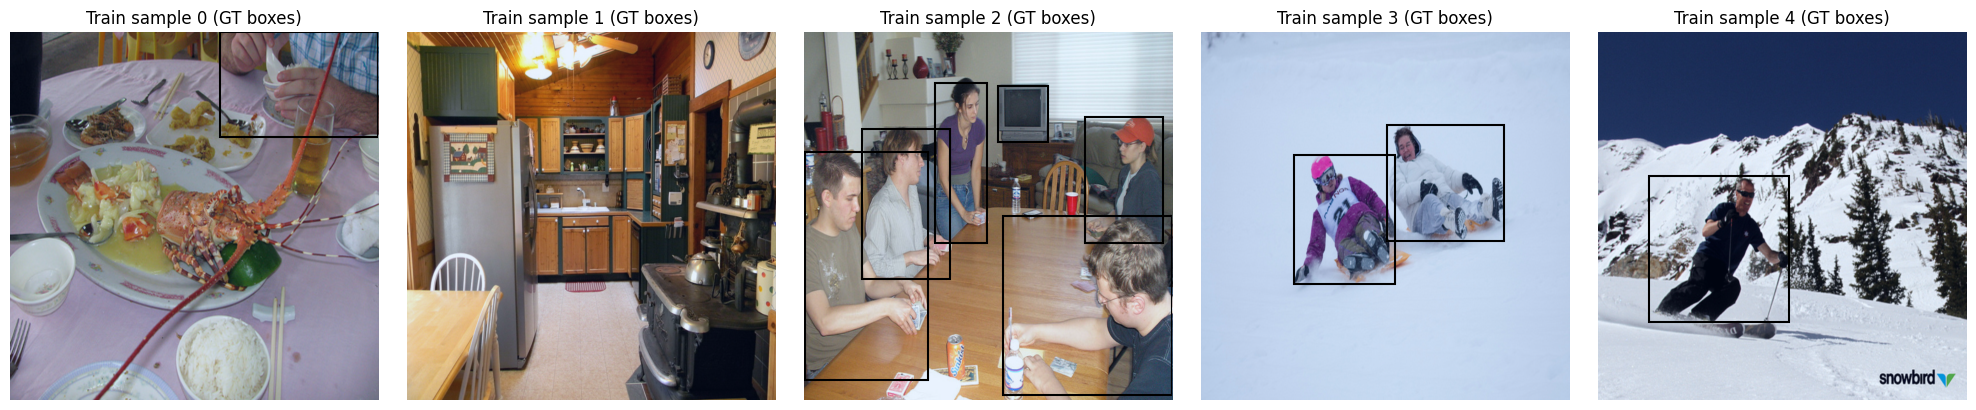

In [21]:
# Visualize 5 training images with GT boxes (from batch["targets"])

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_gt_from_batch(batch, num_images: int = 5):
    images = batch["image_nat"]          # [B, 3, H, W]
    targets = batch["targets"]           # list of length B (each a dict with "boxes")
    B = min(num_images, images.size(0))

    fig, axes = plt.subplots(1, B, figsize=(4 * B, 4))
    if B == 1:
        axes = [axes]

    for i in range(B):
        img = images[i].detach().cpu()

        # Simple per-image min-max normalization for display
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min + 1e-5)
        img_np = img.permute(1, 2, 0).numpy()  # [H, W, 3]

        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f"Train sample {i} (GT boxes)")
        ax.axis("off")

        # GT boxes are stored as [x, y, w, h] (after resizing)
        tgt = targets[i]
        boxes_xywh = tgt["boxes"].detach().cpu()  # [N, 4]

        for box in boxes_xywh:
            x, y, w, h = box.tolist()
            rect = patches.Rectangle(
                (x, y), w, h,
                fill=False,
                linewidth=1.5,
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Take one batch from the training loader and visualize
batch = next(iter(train_loader))
visualize_gt_from_batch(batch, num_images=5)


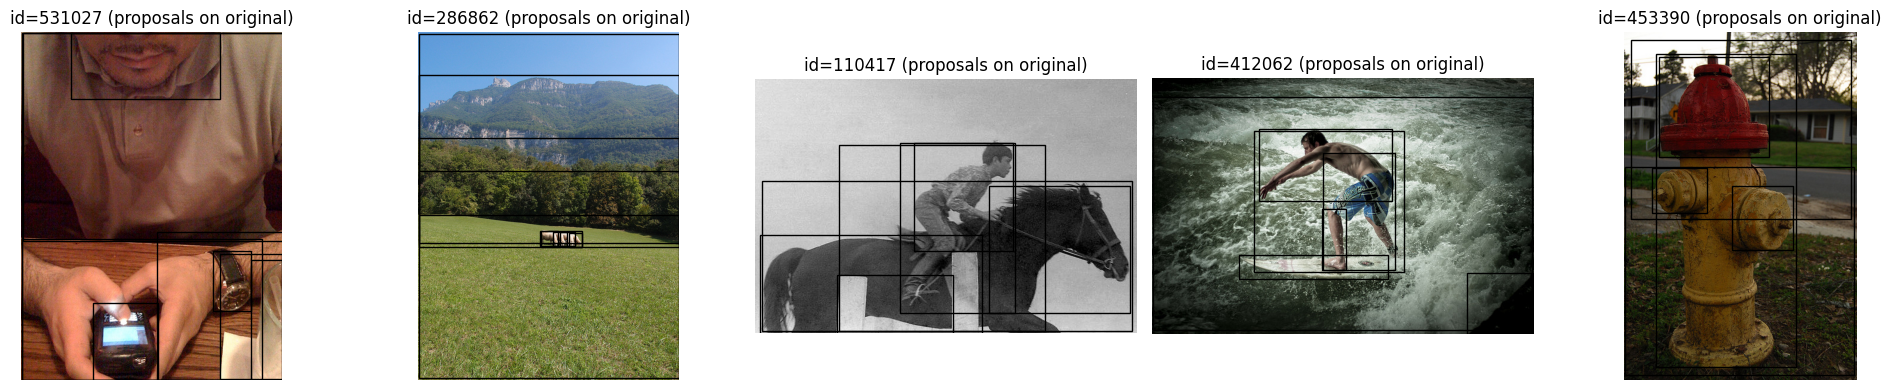

In [25]:
# Visualize 5 training images with *proposal* boxes on the ORIGINAL COCO images

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_proposals_on_original(
    batch,
    num_images: int = 5,
    max_props_per_img: int = 50,
):
    images_nat = batch["image_nat"]      # [B, 3, H_resized, W_resized]
    targets    = batch["targets"]        # list of length B
    proposals_batch = batch["proposals"] # list of length B

    B = min(num_images, len(targets))

    fig, axes = plt.subplots(1, B, figsize=(4 * B, 4))
    if B == 1:
        axes = [axes]

    for i in range(B):
        tgt = targets[i]
        img_id = int(tgt["image_id"].item())  # COCO image id

        # --- Load ORIGINAL COCO image (unscaled) ---
        img_info = coco_train.loadImgs([img_id])[0]
        file_name = img_info["file_name"]
        path = COCO_TRAIN_IMG_DIR / file_name
        img_orig = Image.open(path).convert("RGB")
        orig_w, orig_h = img_orig.size  # (width, height)

        ax = axes[i]
        ax.imshow(img_orig)
        ax.set_title(f"id={img_id} (proposals on original)")
        ax.axis("off")

        # --- Get proposals from the batch (these are in RESIZED coords) ---
        props_list = proposals_batch[i]

        # Handle both list-of-dicts and single-dict cases
        if isinstance(props_list, dict):
            props_entries = [props_list]
        else:
            props_entries = props_list

        if len(props_entries) == 0:
            continue

        # Take the first proposal set (as in your training code)
        prop_entry = props_entries[0]
        boxes_scaled = prop_entry["boxes"].detach().cpu()  # [K, 4] in resized coords (xyxy)
        scores = prop_entry.get("scores", None)

        # Optionally sort by score and keep top-K
        if scores is not None:
            scores = scores.detach().cpu()
            order = torch.argsort(scores, descending=True)
            boxes_scaled = boxes_scaled[order]
        boxes_scaled = boxes_scaled[:max_props_per_img]

        # --- Compute scale factors and unscale boxes back to original image space ---
        # images_nat[i] is the resized tensor for this image
        _, H_resized, W_resized = images_nat[i].shape

        # Resize transform used: (orig_w, orig_h) -> (W_resized, H_resized)
        sx = W_resized / float(orig_w)
        sy = H_resized / float(orig_h)

        boxes_orig = boxes_scaled.clone()
        boxes_orig[:, 0] = boxes_orig[:, 0] / sx  # x1
        boxes_orig[:, 1] = boxes_orig[:, 1] / sy  # y1
        boxes_orig[:, 2] = boxes_orig[:, 2] / sx  # x2
        boxes_orig[:, 3] = boxes_orig[:, 3] / sy  # y2

        # --- Draw proposals on the ORIGINAL image ---
        for box in boxes_orig:
            x1, y1, x2, y2 = box.tolist()
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1),
                w,
                h,
                fill=False,
                linewidth=1.0,
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Take one batch and visualize
batch = next(iter(train_loader))
visualize_proposals_on_original(batch, num_images=5, max_props_per_img=50)


In [ ]:
# Quick diagnostic (no code changes needed in core):
print("Teacher AR:")
evaluate_vclr(model)  # current behavior

print("\nStudent AR (bypassing EMA):")
evaluate_vclr(model.student)

Teacher AR:
Loading and preparing results...
DONE (t=35.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=146.05s).
Accumulating evaluation results...
DONE (t=13.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= sm

Loaded checkpoint vclr_convnext_teacher_student_best.pth
  epoch: 1
[DEBUG] Top detections (box, score):
  [6.536722183227539, 37.24972915649414, 534.4918823242188, 646.9730224609375] score=0.99918133020401
  [291.1060791015625, 75.1116714477539, 647.06201171875, 628.8261108398438] score=0.9893396496772766
  [31.674762725830078, 25.119152069091797, 354.880859375, 534.5178833007812] score=0.24236300587654114
  [198.63807678222656, 26.338163375854492, 330.70513916015625, 342.8634033203125] score=0.19014307856559753
  [0.6045751571655273, 545.8639526367188, 115.53612518310547, 649.0536499023438] score=0.14374729990959167


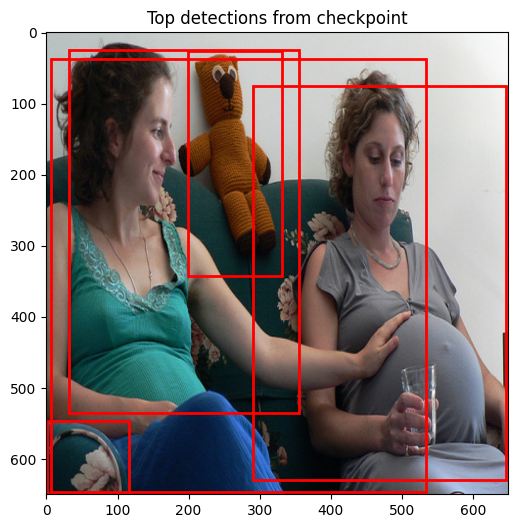

In [16]:
# === Debug: show top detections from checkpoint ===
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CKPT_PATH = Path("vclr_convnext_teacher_student_best.pth")
if not CKPT_PATH.is_file():
    print(f"[WARN] Checkpoint not found: {CKPT_PATH}")
else:
    ckpt = torch.load(CKPT_PATH, map_location=device)
    missing, unexpected = model.load_state_dict(ckpt.get("model_state", ckpt), strict=False)
    print("Loaded checkpoint", CKPT_PATH)
    if "epoch" in ckpt:
        print("  epoch:", ckpt["epoch"])
    if missing or unexpected:
        print("  missing keys:", missing)
        print("  unexpected keys:", unexpected)

# Grab one train sample and run teacher forward
sample = train_dataset[0]
img = sample["image_nat"].unsqueeze(0).to(device)
net_vis = model.teacher if hasattr(model, "teacher") else model
net_vis.eval()
with torch.no_grad():
    outs, _ = net_vis(img, None, None, "nat")

if not outs or outs[0]["boxes"].numel() == 0:
    print("[DEBUG] No detections on sample 0")
else:
    boxes = outs[0]["boxes"].cpu()
    scores = outs[0].get("scores", torch.tensor([])).cpu()
    topk = min(5, boxes.shape[0])
    idx = torch.topk(scores, k=topk).indices if scores.numel() else torch.arange(topk)
    print("[DEBUG] Top detections (box, score):")
    for i in idx:
        b = boxes[i].tolist()
        s = float(scores[i]) if scores.numel() else None
        print(f"  {b} score={s}")
    # Plot first detection
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(sample["image_nat"].permute(1,2,0))
    for i in idx:
        x1,y1,x2,y2 = boxes[i]
        ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none'))
    ax.set_title("Top detections from checkpoint")
    plt.show()



Loaded checkpoint vclr_convnext_teacher_student_best.pth
[DEBUG] Val image path: C:/workspace/vclr/datasets/uvo_videos_dense_frames/4qVBgiGwi2c/119.png
[DEBUG] Top detections on random val sample:
  [351.1546325683594, 2.218212127685547, 655.005615234375, 590.3692016601562] score=0.6566521525382996
  [71.93765258789062, -0.2311408519744873, 633.4605102539062, 651.3801879882812] score=0.37907394766807556
  [460.2274475097656, 165.16053771972656, 574.6343383789062, 233.2083282470703] score=0.17975763976573944
  [349.91064453125, 152.8550567626953, 561.1878051757812, 304.91839599609375] score=0.16104111075401306
  [1.1507500410079956, 402.2743835449219, 102.71530151367188, 651.0999755859375] score=0.14726927876472473
  [314.14971923828125, 74.92078399658203, 613.9085693359375, 414.1806335449219] score=0.14325426518917084
  [318.9817810058594, 29.321773529052734, 590.874755859375, 284.6890869140625] score=0.1353621482849121
  [516.6287231445312, 182.71719360351562, 564.0690307617188, 228.2

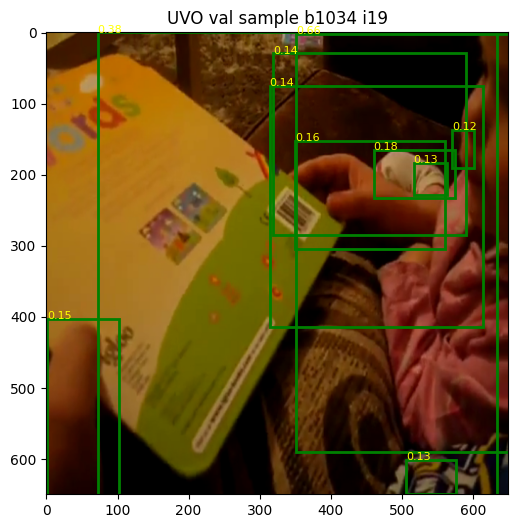

In [26]:
# === Debug: random UVO val frame with detections ===
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import random

# Load checkpoint into model
CKPT_PATH = Path("vclr_convnext_teacher_student_best.pth")
if CKPT_PATH.is_file():
    ckpt = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(ckpt.get("model_state", ckpt), strict=False)
    print("Loaded checkpoint", CKPT_PATH)
else:
    print("[WARN] checkpoint not found", CKPT_PATH)

net_vis = model.teacher if hasattr(model, "teacher") else model
net_vis.eval()

# Pick a random batch index and image index
num_batches = len(val_loader)
if num_batches == 0:
    print("[WARN] val_loader is empty")
else:
    rand_b = random.randint(0, num_batches-1)
    images = img_ids = orig_sizes = None
    for i, batch in enumerate(val_loader):
        if i == rand_b:
            images, img_ids, orig_sizes = batch
            break
    if images is None:
        print("[WARN] could not fetch batch")
    else:
        rand_i = random.randint(0, images.shape[0]-1)
        img_t = images[rand_i].unsqueeze(0).to(device, non_blocking=True)
        with torch.no_grad():
            outs, _ = net_vis(img_t, None, None, "nat")
        if not outs or outs[0]["boxes"].numel() == 0:
            print(f"[WARN] No detections on val sample batch {rand_b} idx {rand_i}")
        else:
            boxes = outs[0]["boxes"].cpu()
            scores = outs[0].get("scores", torch.tensor([])).cpu()
            topk = min(10, boxes.shape[0])
            idx = torch.topk(scores, k=topk).indices if scores.numel() else torch.arange(topk)
            # Resolve image path if available
            img_path = None
            try:
                img_info = coco_nonvoc.loadImgs([int(img_ids[rand_i])])[0]
                img_path = (NONVOC_IMG_DIR / img_info['file_name']).as_posix()
            except Exception:
                pass
            if img_path:
                print(f"[DEBUG] Val image path: {img_path}")
            print("[DEBUG] Top detections on random val sample:")
            for j in idx:
                b = boxes[j].tolist()
                s = float(scores[j]) if scores.numel() else None
                print(f"  {b} score={s}")
            # Unnormalize image for display (val loader normalizes)
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            img_np = images[rand_i].cpu() * std + mean
            img_np = img_np.permute(1,2,0).clamp(0,1).numpy()
            fig, ax = plt.subplots(1,1, figsize=(6,6))
            ax.imshow(img_np)
            for j in idx:
                x1,y1,x2,y2 = boxes[j]
                ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none'))
                if scores.numel():
                    ax.text(x1, y1, f"{float(scores[j]):.2f}", color='yellow', fontsize=8)
            ax.set_title(f"UVO val sample b{rand_b} i{rand_i}")
            plt.show()



loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


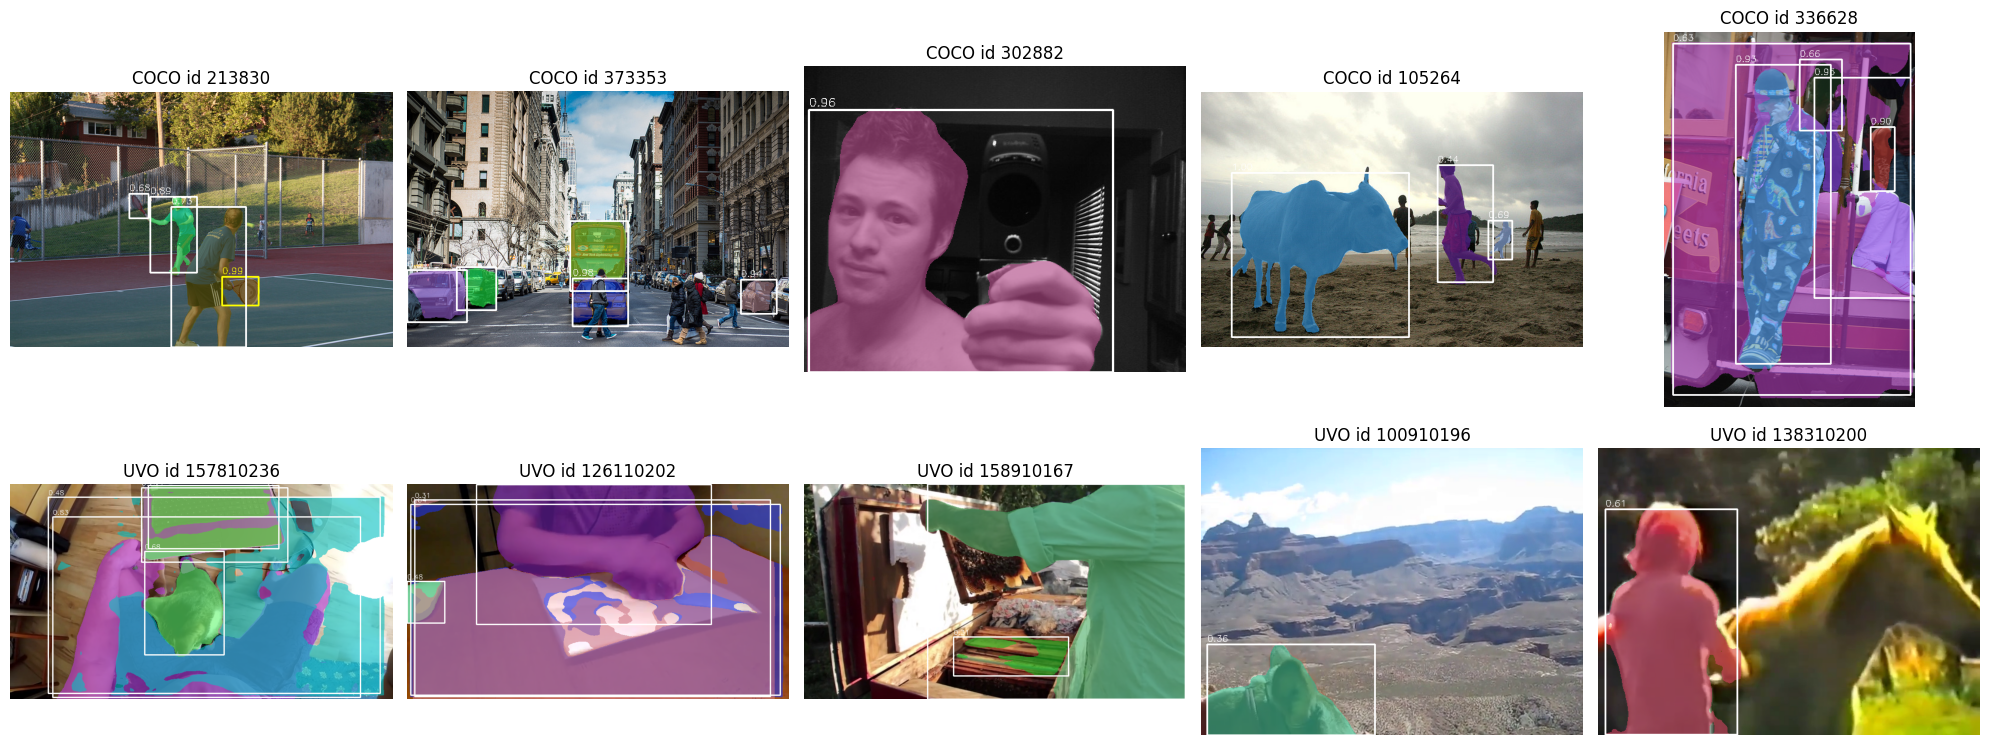

In [18]:
# === YOLACT pretrained visualization (COCO + UVO) ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import random
from pycocotools.coco import COCO
from yolact import Yolact
from data.config import cfg, set_cfg
from utils.augmentations import FastBaseTransform
from layers.output_utils import postprocess

# Fresh inference net straight from the COCO-pretrained checkpoint
set_cfg("yolact_resnet50_config")
# Ensure missing cfg flags exist for this fork
if not hasattr(cfg, "mask_proto_debug"):
    cfg.mask_proto_debug = False
if not hasattr(cfg, "eval_mask_branch"):
    cfg.eval_mask_branch = True
if not hasattr(cfg, "use_maskiou"):
    cfg.use_maskiou = False

vis_net = Yolact()
vis_net.load_weights(str(YOLACT_CKPT))
vis_net = vis_net.to(device)
vis_net.eval()
if hasattr(vis_net, "detect"):
    vis_net.detect.conf_thresh = 0.3
    if hasattr(vis_net.detect, "nms_thresh"):
        vis_net.detect.nms_thresh = 0.5
    vis_net.detect.nms_top_k = 200
    vis_net.detect.max_num_detections = 100
    vis_net.detect.use_fast_nms = True
    vis_net.detect.use_cross_class_nms = False

# FastBaseTransform assumes CUDA; fall back to a simple CPU path if needed
if device.type != "cuda":
    print("[WARN] CUDA not available; using slower CPU preprocessing")
    def _cpu_transform(img_bgr: np.ndarray) -> torch.Tensor:
        img = torch.from_numpy(img_bgr).float()
        img = img.permute(2, 0, 1).unsqueeze(0)  # 1,C,H,W
        img = img[:, (2,1,0), :, :] / 255.0      # to RGB, [0,1]
        return img
    fast_transform = _cpu_transform
else:
    fast_transform = FastBaseTransform()

# Helper: pick random image paths

def _sample_paths(coco_api: COCO, img_dir: Path, k: int):
    ids = coco_api.getImgIds()
    if len(ids) == 0:
        return []
    chosen = random.sample(ids, min(k, len(ids)))
    paths = []
    for img_id in chosen:
        info = coco_api.loadImgs([img_id])[0]
        path = Path(img_dir) / info["file_name"]
        if not path.is_file():
            alt = path.with_suffix(".jpg" if path.suffix.lower() == ".png" else ".png")
            if alt.is_file():
                path = alt
        paths.append((img_id, path))
    return paths

# Helper: run Yolact and overlay top detections

def _run_one(image_path: Path, score_thresh: float = 0.3, max_show: int = 5):
    frame = cv2.imread(str(image_path))
    if frame is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    h, w = frame.shape[:2]

    if device.type == "cuda":
        batch = fast_transform(torch.from_numpy(frame).float().unsqueeze(0).to(device))
    else:
        batch = fast_transform(frame)
    with torch.no_grad():
        preds = vis_net(batch)

    classes, scores, boxes, masks = postprocess(preds, w, h, score_threshold=score_thresh)
    if boxes.numel() == 0:
        return frame[:, :, ::-1].astype(np.float32) / 255.0, []

    boxes = boxes.cpu().numpy().astype(int)
    scores = scores.cpu().numpy()
    masks = masks.cpu().numpy() if isinstance(masks, torch.Tensor) else np.zeros((0, h, w))

    vis_img = frame[:, :, ::-1].astype(np.float32) / 255.0  # BGR -> RGB
    det_info = []
    rng = np.random.default_rng()
    for j in range(min(max_show, boxes.shape[0])):
        color = rng.random(3)
        if masks.shape[0] > j:
            m = masks[j].astype(bool)
            vis_img[m] = vis_img[m] * 0.4 + color * 0.6
        x1, y1, x2, y2 = boxes[j]
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), (color * 255).astype(np.uint8).tolist(), 2)
        cv2.putText(vis_img, f"{scores[j]:.2f}", (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color * 255).astype(np.uint8).tolist(), 1, cv2.LINE_AA)
        det_info.append({"score": float(scores[j]), "box": boxes[j].tolist()})

    vis_img = np.clip(vis_img, 0.0, 1.0)
    return vis_img, det_info

# Sample 5 random images from COCO val and 5 from UVO frames
coco_val_api = COCO(str(COCO_VAL_JSON))
coco_samples = _sample_paths(coco_val_api, COCO_VAL_IMG_DIR, 5)
uvo_samples = _sample_paths(coco_nonvoc, NONVOC_IMG_DIR, 5)

cols = max(len(coco_samples), len(uvo_samples), 1)
fig, axes = plt.subplots(2, cols, figsize=(4 * cols, 8))
axes = np.array(axes).reshape(2, cols)

for idx, (img_id, path) in enumerate(coco_samples):
    vis_img, info = _run_one(path)
    axes[0, idx].imshow(vis_img)
    axes[0, idx].set_title(f"COCO id {img_id}")
    axes[0, idx].axis("off")

for idx, (img_id, path) in enumerate(uvo_samples):
    vis_img, info = _run_one(path)
    axes[1, idx].imshow(vis_img)
    axes[1, idx].set_title(f"UVO id {img_id}")
    axes[1, idx].axis("off")

plt.tight_layout()
plt.show()




loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]
WARNING imgsz=[650] must be multiple of max stride 32, updating to [672]


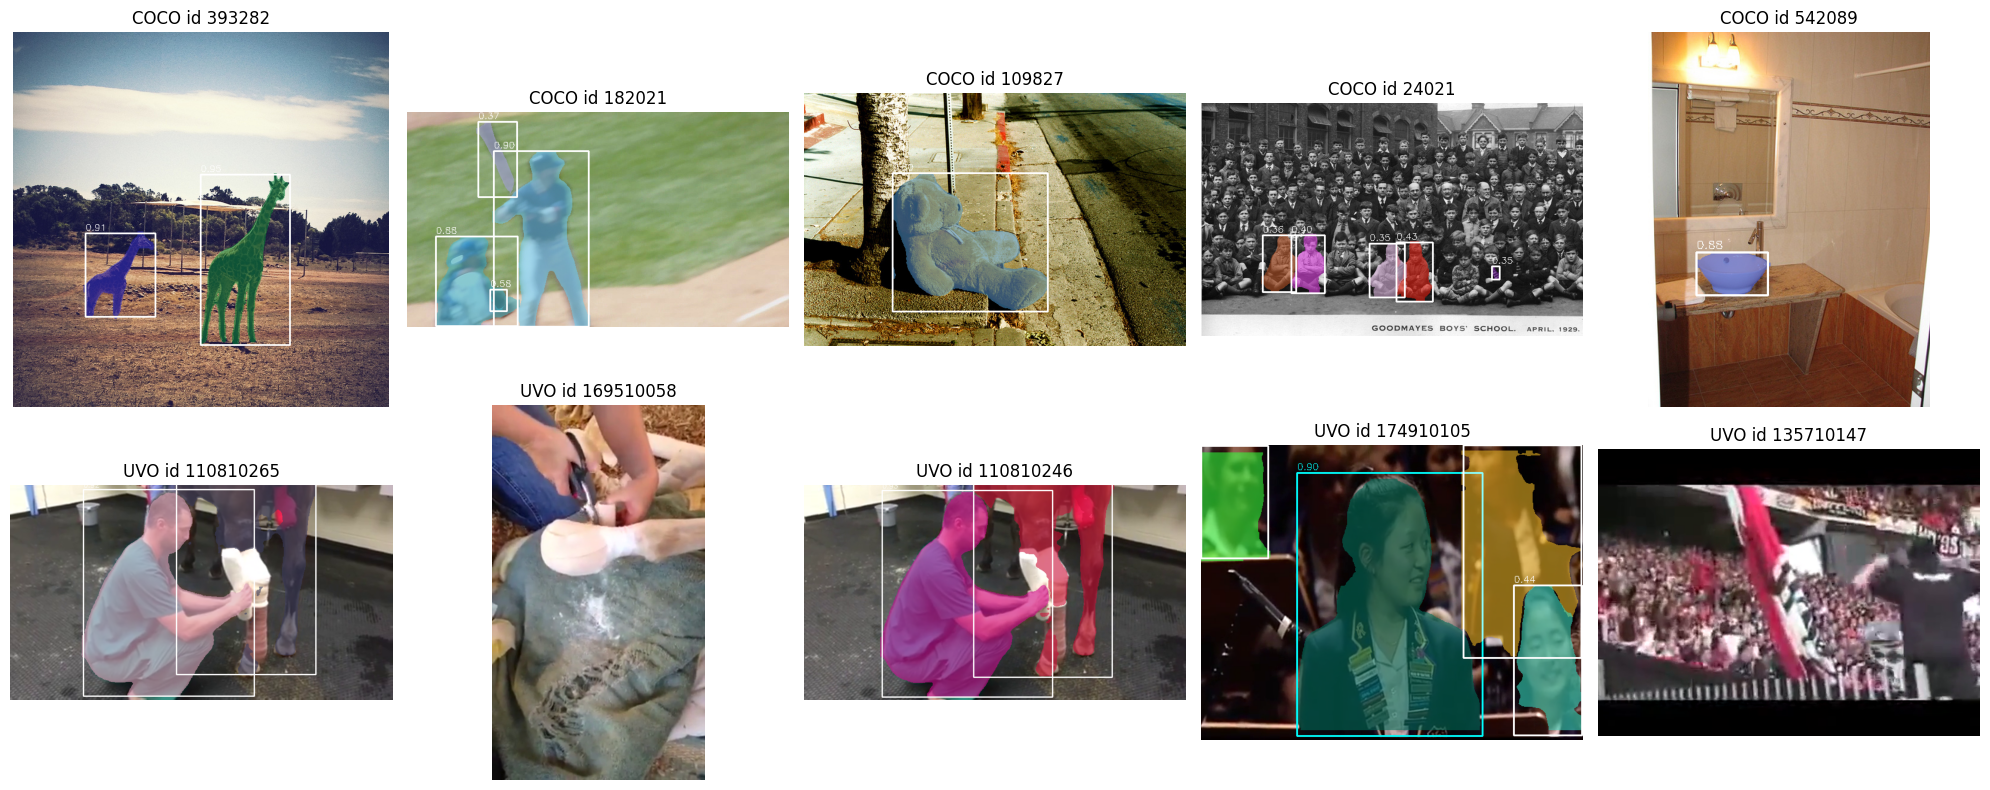

In [31]:
# === YOLOv11-small segmentation visualization (COCO + UVO) ===
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

try:
    from ultralytics import YOLO
except ImportError:
    print("[WARN] ultralytics not installed; install it to run YOLOv11 seg viz")
    raise SystemExit

YOLO11_WEIGHTS = Path("yolo11s-seg.pt")
if not YOLO11_WEIGHTS.is_file():
    print(f"[WARN] weights not found: {YOLO11_WEIGHTS}. Download yolo11s-seg.pt and place it here.")
    raise SystemExit

# Load YOLOv11 small segmentation model
model_y11 = YOLO(str(YOLO11_WEIGHTS))
if device.type == "cuda" and device.index is not None:
    model_y11.to(device.index)
else:
    model_y11.to("cpu")
model_y11.eval()

# Helper to sample image paths

def _sample_paths(coco_api: COCO, img_dir: Path, k: int):
    ids = coco_api.getImgIds()
    if len(ids) == 0:
        return []
    chosen = random.sample(ids, min(k, len(ids)))
    out = []
    for img_id in chosen:
        info = coco_api.loadImgs([img_id])[0]
        path = Path(img_dir) / info["file_name"]
        if not path.is_file():
            alt = path.with_suffix(".jpg" if path.suffix.lower() == ".png" else ".png")
            if alt.is_file():
                path = alt
        out.append((img_id, path))
    return out

# Run YOLOv11 seg on one image and overlay results

def _run_yolo11(image_path: Path, conf: float = 0.3, max_show: int = 5):
    frame = cv2.imread(str(image_path))
    if frame is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    pred = model_y11.predict(
        source=str(image_path),
        imgsz=IMG_SIZE,
        conf=conf,
        device=model_y11.device,
        verbose=False,
    )[0]

    boxes = pred.boxes.xyxy.cpu().numpy() if pred.boxes is not None else np.zeros((0,4))
    scores = pred.boxes.conf.cpu().numpy() if pred.boxes is not None else np.zeros((0,))
    masks = pred.masks.data if pred.masks is not None else None

    vis = rgb.astype(np.float32) / 255.0

    # Resize masks to original image size before overlay
    masks_np = []
    if masks is not None and masks.numel() > 0:
        masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=(rgb.shape[0], rgb.shape[1]), mode="bilinear", align_corners=False).squeeze(1)
        masks_np = masks_resized.cpu().numpy()

    rng = np.random.default_rng()
    for j in range(min(max_show, boxes.shape[0])):
        color = rng.random(3)
        if len(masks_np) > j:
            m = masks_np[j] > 0.5
            vis[m] = vis[m] * 0.4 + color * 0.6
        x1, y1, x2, y2 = boxes[j].astype(int)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (color * 255).astype(np.uint8).tolist(), 2)
        cv2.putText(vis, f"{scores[j]:.2f}", (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color * 255).astype(np.uint8).tolist(), 1, cv2.LINE_AA)

    vis = np.clip(vis, 0.0, 1.0)
    return vis

# Sample 5 random images from COCO val and 5 from UVO frames
coco_val_api = COCO(str(COCO_VAL_JSON))
coco_samples = _sample_paths(coco_val_api, COCO_VAL_IMG_DIR, 5)

vis_dir = Path("vis")
vis_dir.mkdir(exist_ok=True, parents=True)
uvo_samples = _sample_paths(coco_nonvoc, NONVOC_IMG_DIR, 5)

cols = max(len(coco_samples), len(uvo_samples), 1)
fig, axes = plt.subplots(2, cols, figsize=(4 * cols, 8))
axes = np.array(axes).reshape(2, cols)

for idx, (img_id, path) in enumerate(coco_samples):
    vis_img = _run_yolo11(path)
    axes[0, idx].imshow(vis_img)
    axes[0, idx].set_title(f"COCO id {img_id}")
    axes[0, idx].axis("off")

    out = (vis_img * 255.0).clip(0, 255).astype(np.uint8)
    cv2.imwrite(str(vis_dir / f"coco_{img_id}.png"), cv2.cvtColor(out, cv2.COLOR_RGB2BGR))

for idx, (img_id, path) in enumerate(uvo_samples):
    vis_img = _run_yolo11(path)
    axes[1, idx].imshow(vis_img)
    axes[1, idx].set_title(f"UVO id {img_id}")
    axes[1, idx].axis("off")

    out = (vis_img * 255.0).clip(0, 255).astype(np.uint8)
    cv2.imwrite(str(vis_dir / f"uvo_{img_id}.png"), cv2.cvtColor(out, cv2.COLOR_RGB2BGR))

plt.tight_layout()
plt.show()



